Разведочный анализ датасета изображений рентгеновских снимков
Цели ноутбука:

Провести анализ характеристик изображений
Провести анализ метаданных изображений
Провести визуальный анализ изображений
Визуализировать данные
Провести первичную предобработку
Сделать выводы по структуре данных
Для разведочного анализа используется подготовленный датасет, состоящий из рентген-снимков

In [ ]:
rm -rf dataset_clean

##Импорт библиотек

In [1]:
import zipfile
import os
import shutil
import random
import hashlib
import seaborn as sns
import os
import cv2

import gdown

from tqdm.auto import tqdm

from PIL import Image, ExifTags, ImageOps, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.nn.functional as F
import random

# Импорт необходимых библиотек
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [3]:
from data_utils import setup_environment, download_and_extract, print_directory_structure, analyze_dataset
from data_cleaner import find_duplicates, visualize_duplicates, clean_dataset, copy_test_folder

## Загрузка файлов

In [4]:
# 1. Настройка окружения
DRIVE_DIR, DATASET_DIR, ZIP_PATH = setup_environment()

# 2. Загрузка данных
FILE_ID = "1ltYQh_bwNuJJ1nr91w3hZlGcnxrFOyF6"
download_and_extract(FILE_ID, ZIP_PATH, DATASET_DIR)

# 3. Очистка данных
CLASSES = ['NORMAL', 'PNEUMONIA']
TRAIN_DIR = os.path.join(DATASET_DIR, "chest_xray/train")
CLEAN_TRAIN_DIR = os.path.join(DATASET_DIR, "chest_xray_clean/train")

Mounted at /content/drive
Данные распакованы в: /content/dataset


In [ ]:
import tarfile

# Пути к данным
DATASET_DIR_OCT = os.path.join(os.getcwd(), "dataset_oct")
ZIP_PATH_OCT = os.path.join(DRIVE_DIR, "OCT2017.tar.gz")

# Создание папки для датасета, если её нет
os.makedirs(DATASET_DIR_OCT, exist_ok=True)

# ID файла на Google Drive
file_id = "1Rfccuck7bN4HvO4BRr8RRorPcZw5v0AN"

# Загрузка архива, если он ещё не загружен
if os.path.exists(ZIP_PATH_OCT):
    print("Архив уже добавлен")
else:
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        ZIP_PATH_OCT,  # Исправлено на использование ZIP_PATH
        quiet=False,
    )

# Распаковка архива
with tarfile.open(ZIP_PATH_OCT, 'r:gz') as tar_ref:
        tar_ref.extractall(DATASET_DIR_OCT) # Распаковка в папку dataset_oct

# Проверка структуры папок
print(f"Количество папок: {len(os.listdir(DATASET_DIR_OCT))}")


Downloading...
From (original): https://drive.google.com/uc?id=1Rfccuck7bN4HvO4BRr8RRorPcZw5v0AN
From (redirected): https://drive.google.com/uc?id=1Rfccuck7bN4HvO4BRr8RRorPcZw5v0AN&confirm=t&uuid=1aa189a3-1826-4524-ad16-967cf535d22b
To: /content/drive/MyDrive/OCT2017.tar.gz
100%|██████████| 5.79G/5.79G [00:57<00:00, 102MB/s]


Количество папок: 1


# EDA

## Анализ дубликатов рентгеновских снимков легких


Класс: NORMAL
Всего пар дубликатов: 1


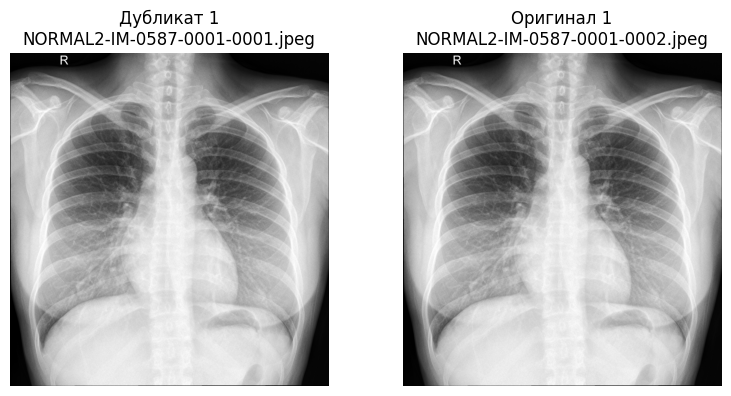


Класс: PNEUMONIA
Всего пар дубликатов: 25


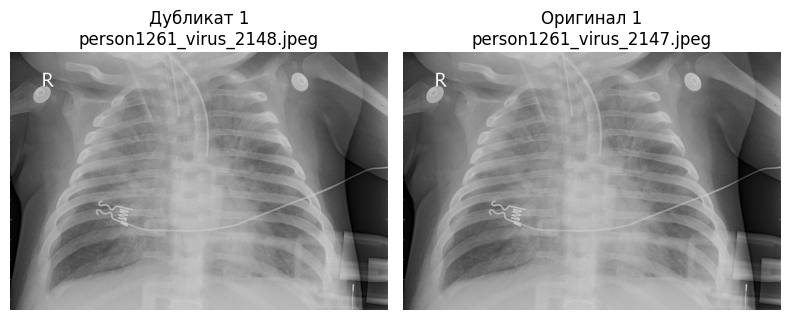

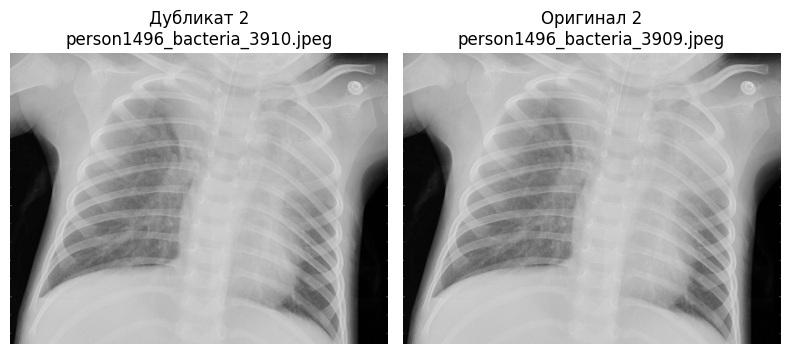

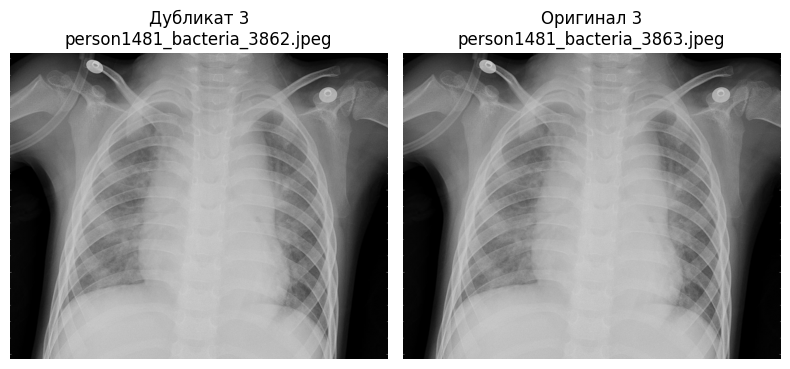

Обработка классов: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Итоги:
Скопировано уникальных файлов: 5206
Пропущено дубликатов: 26
Очищенный датасет сохранен в: /content/dataset/chest_xray_clean/train


In [5]:
# Поиск дубликатов
duplicates_dict = {}
all_duplicates_files = {}

for cls in CLASSES:
    path = os.path.join(TRAIN_DIR, cls)
    dup_list, dup_files = find_duplicates(path)
    if dup_list:
        duplicates_dict[cls] = dup_list
        all_duplicates_files[cls] = dup_files

# Визуализация
if duplicates_dict:
    visualize_duplicates(duplicates_dict)
else:
    print("Дубликаты не найдены")

# Создание чистого датасета
clean_dataset_path = clean_dataset(
    TRAIN_DIR,
    CLEAN_TRAIN_DIR,
    CLASSES,
    all_duplicates_files
)

print(f"Очищенный датасет сохранен в: {clean_dataset_path}")

Обнаружился 1 дубликат в классе Normal и 25 дубликатов в классе PNEUMONIA

In [6]:
src_dir = os.path.join(DATASET_DIR, "chest_xray")
clean_dir = os.path.join(DATASET_DIR, "chest_xray_clean")
copy_test_folder(src_dir, clean_dir)

Папка test скопирована в /content/dataset/chest_xray_clean/test


'/content/dataset/chest_xray_clean/test'

## Анализ дубликатов OCT

Поиск дубликатов: 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]



Класс: CNV
Всего пар дубликатов: 5570


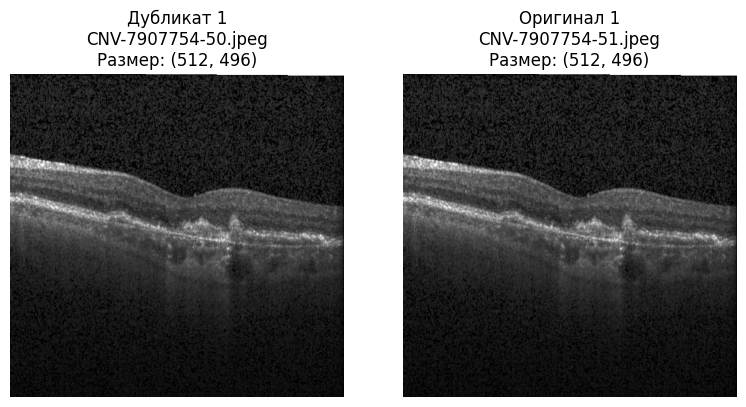

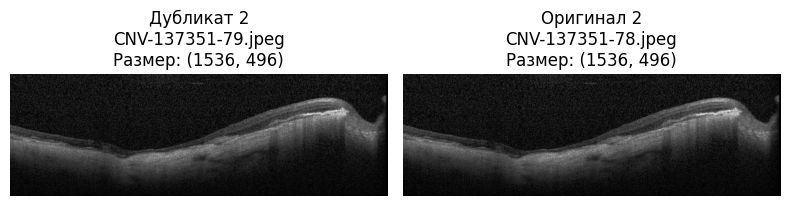

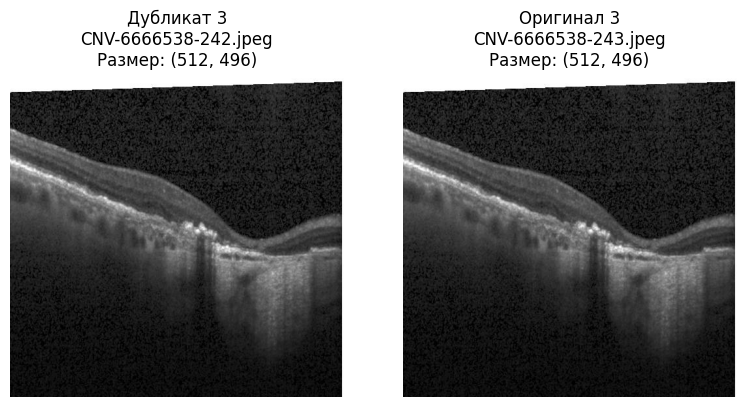


Класс: DME
Всего пар дубликатов: 409


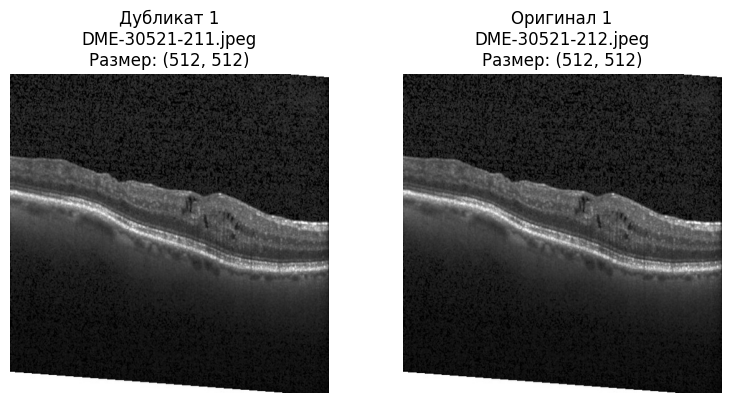

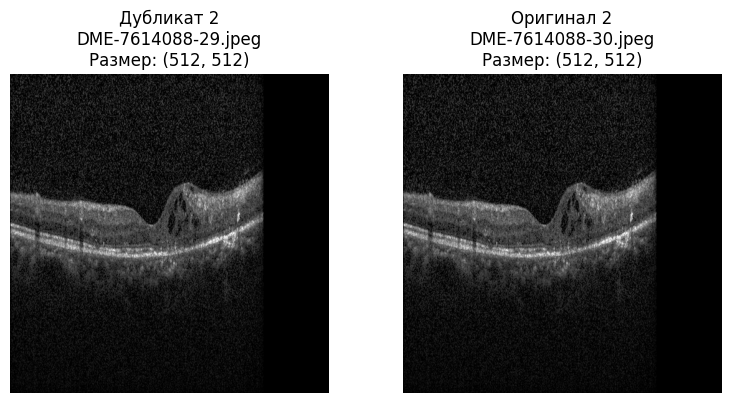

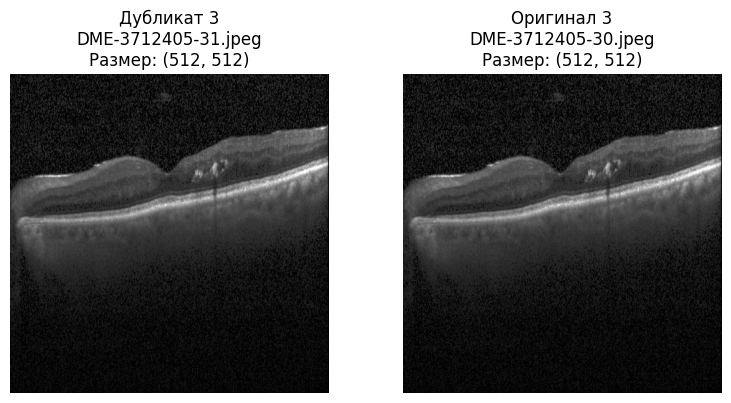


Класс: DRUSEN
Всего пар дубликатов: 599


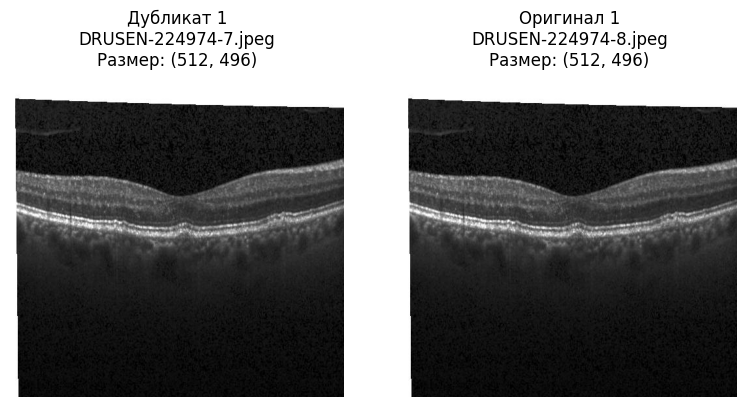

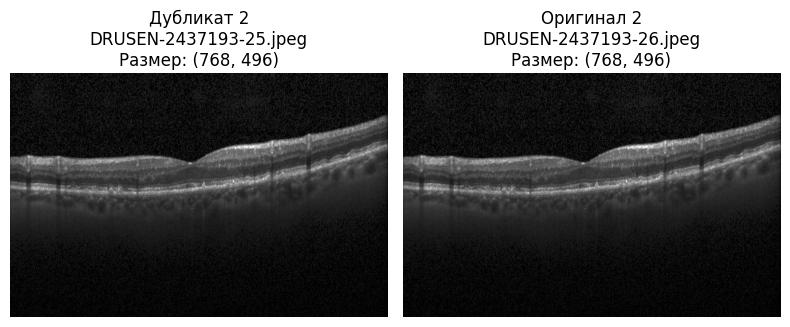

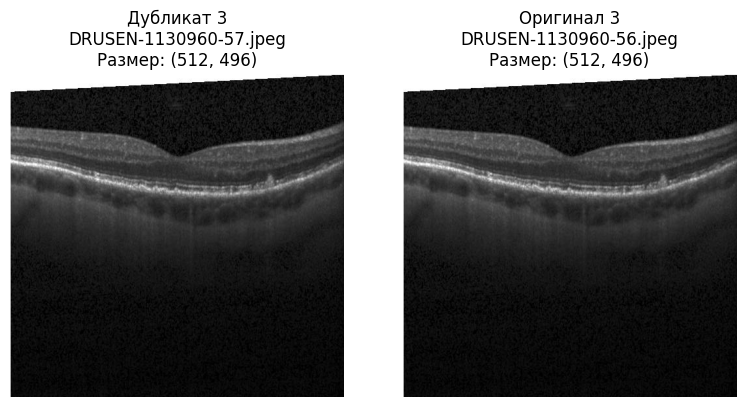


Класс: NORMAL
Всего пар дубликатов: 184


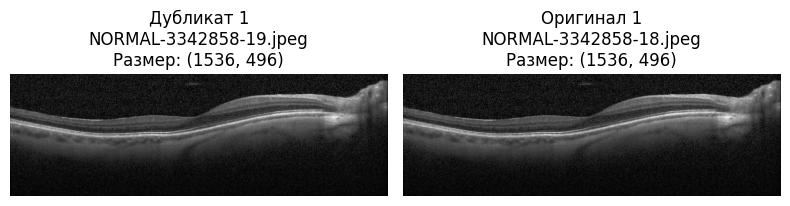

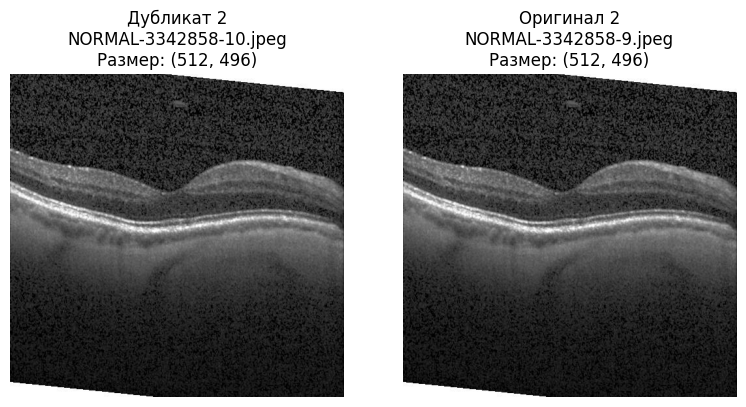

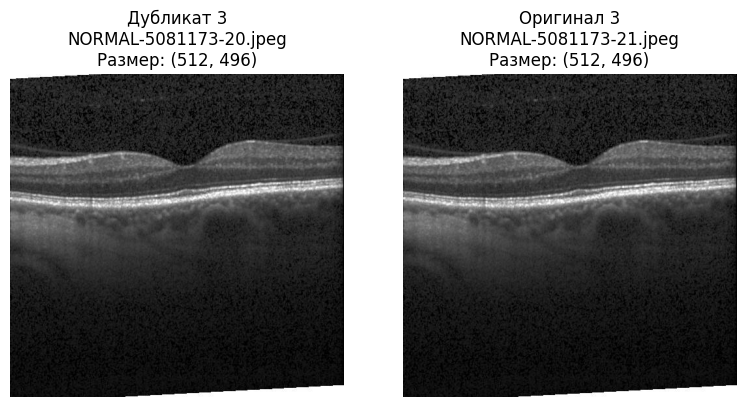


Создание очищенного датасета...


Обработка классов:  25%|██▌       | 1/4 [00:05<00:17,  5.71s/it]


Класс CNV:
  Скопировано уникальных файлов: 31635
  Пропущено дубликатов: 5570


Обработка классов:  50%|█████     | 2/4 [00:07<00:07,  3.50s/it]


Класс DME:
  Скопировано уникальных файлов: 10939
  Пропущено дубликатов: 409


Обработка классов:  75%|███████▌  | 3/4 [00:10<00:03,  3.40s/it]


Класс DRUSEN:
  Скопировано уникальных файлов: 8017
  Пропущено дубликатов: 599


Обработка классов: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]


Класс NORMAL:
  Скопировано уникальных файлов: 26131
  Пропущено дубликатов: 184

Итоги:
Всего скопировано уникальных файлов: 76722
Всего пропущено дубликатов: 6762

Очищенный датасет сохранен в: dataset_clean/OCT2017/train


In [ ]:
# Пути к папкам
DATASET_DIR = 'dataset_oct/OCT2017/train'
CLEAN_DATASET_DIR = 'dataset_clean/OCT2017/train'  # Папка для очищенного датасета
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Словарь для хранения дубликатов по классам
duplicates_dict = {}
# Словарь для хранения всех файлов-дубликатов по классам
all_duplicates_files = {}

# Поиск дубликатов для каждого класса
for cls in tqdm(classes, desc="Поиск дубликатов"):
    path = os.path.join(DATASET_DIR, cls)
    dup_list, dup_files = find_duplicates(path)
    if dup_list:
        duplicates_dict[cls] = dup_list
        all_duplicates_files[cls] = dup_files

# Визуализация дубликатов (если они есть)
if duplicates_dict:
    show_duplicates(duplicates_dict)
else:
    print("\nДубликаты не найдены.")

# Создание очищенного датасета
print("\nСоздание очищенного датасета...")
total_copied = 0
total_skipped = 0

for cls in tqdm(classes, desc="Обработка классов"):
    # Пути к исходной и новой папкам класса
    src_class_dir = os.path.join(DATASET_DIR, cls)
    dst_class_dir = os.path.join(CLEAN_DATASET_DIR, cls)

    # Получаем множество дубликатов для этого класса
    dup_files = all_duplicates_files.get(cls, set())

    # Копируем уникальные файлы
    copied, skipped = copy_unique_files(src_class_dir, dst_class_dir, dup_files)
    total_copied += copied
    total_skipped += skipped

    print(f"\nКласс {cls}:")
    print(f"  Скопировано уникальных файлов: {copied}")
    print(f"  Пропущено дубликатов: {skipped}")

print(f"\nИтоги:")
print(f"Всего скопировано уникальных файлов: {total_copied}")
print(f"Всего пропущено дубликатов: {total_skipped}")
print(f"\nОчищенный датасет сохранен в: {CLEAN_DATASET_DIR}")

#Аугментации

## Вспомогательные функции

In [7]:
# Установка seed для воспроизводимости результатов
seed = 42

# Задаем seed для генераторов псевдослучайных чисел в Python, PyTorch и NumPy
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

torch.backends.cudnn.deterministic = True  # Делает CuDNN детерминированным
torch.backends.cudnn.benchmark = False     # Отключает авто-тюнинг (может менять поведение)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Для некоторых версий CUDA
torch.use_deterministic_algorithms(True)

# Создаем генератор случайных чисел PyTorch и задаем ему seed
g = torch.Generator()
g.manual_seed(seed)

# Функция для установки seed в DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Параметры для DataLoader
batch_size = 32
num_workers = 4  # Количество процессов для загрузки данных


## Загрузка датасета рентген

In [8]:
clean_train_dir = 'dataset/chest_xray_clean/train'
test_dir ='dataset/chest_xray/test'

In [10]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_augmented_samples(data_dir, transform, n_samples=5):
    """
    Показывает оригинальное и аугментированные изображения из датасета

    Параметры:
        data_dir (str): Путь к директории с данными
        transform: Трансформации для аугментации
        n_samples (int): Количество аугментированных версий для показа
    """
    # Выбираем случайный класс
    class_dir = random.choice(os.listdir(data_dir))
    class_path = os.path.join(data_dir, class_dir)

    # Выбираем случайное изображение
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    # Загружаем изображение
    try:
        img = Image.open(img_path).convert('L')  # Конвертируем в grayscale
    except Exception as e:
        print(f"Ошибка загрузки изображения {img_path}: {e}")
        return

    # Показываем оригинальное изображение
    print(f"\nOriginal image: {img_path} (Class: {class_dir})")
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Original Image\nClass: {class_dir}')
    plt.show()

    # Показываем аугментированные версии
    print(f"Augmented versions (n={n_samples}):")
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        aug_img = transform(img)
        plt.subplot(1, n_samples, i+1)
        plt.imshow(aug_img[0], cmap='gray')  # Для тензора [C,H,W]
        plt.axis('off')
        plt.title(f'Aug #{i+1}')
    plt.tight_layout()
    plt.show()


## Аугментация

In [9]:
# Преобразования для тестового набора данных
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера до 128x128
    transforms.ToTensor(),  # Преобразование в тензор
])

In [10]:
# Преобразования для тестового набора данных
test_transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера до 224x224
    transforms.ToTensor(),  # Преобразование в тензор
])

### Базовая - только Resize

In [11]:
# Преобразования для обучающего набора данных
train_transform_base = transforms.Compose([
            transforms.Resize((128, 128)),  # Изменение размера до 128x128
            transforms.ToTensor(),  # Преобразование в тензор
])


In [12]:
# Преобразования для обучающего набора данных
train_transform_base_224 = transforms.Compose([
            transforms.Resize((224, 224)),  # Изменение размера до 128x128
            transforms.ToTensor(),  # Преобразование в тензор
])


Original image: dataset/chest_xray_clean/train/PNEUMONIA/person1165_virus_1959.jpeg (Class: PNEUMONIA)


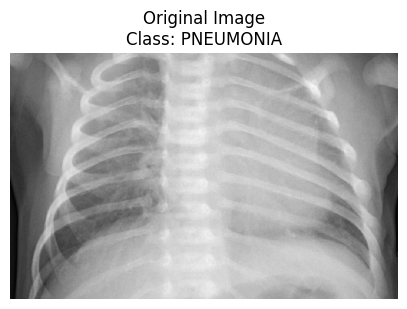

Augmented versions (n=1):


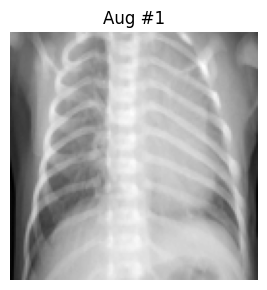

In [15]:
show_augmented_samples(clean_train_dir, train_transform_base, n_samples=1)

In [13]:
train_data_base = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_base)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_base))
train_size = len(train_data_base) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_base, val_data_base = random_split(train_data_base, [train_size, val_size])


In [14]:
train_data_base_224 = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_base_224)
test_data_224 = datasets.ImageFolder(root=test_dir, transform=test_transform_224)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_base_224))
train_size = len(train_data_base_224) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_base_224, val_data_base_224 = random_split(train_data_base_224, [train_size, val_size])


In [15]:
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,  # Для тестовых данных перемешивание не требуется
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [16]:
test_loader_224 = DataLoader(
    test_data_224,
    batch_size=batch_size,
    shuffle=False,  # Для тестовых данных перемешивание не требуется
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [17]:
train_loader_base =  DataLoader(
    train_data_base,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_base =  DataLoader(
    val_data_base,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [18]:
train_loader_base_224 =  DataLoader(
    train_data_base_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_base_224 =  DataLoader(
    val_data_base_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

### 1 аугментация - поворот

In [18]:
# Преобразования для обучающего набора данных
train_transform_rotation = transforms.Compose([
            transforms.Resize((128, 128)),  # Изменение размера до 128x128
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),  # Преобразование в тензор
])



Original image: dataset/chest_xray_clean/train/NORMAL/NORMAL2-IM-0620-0001.jpeg (Class: NORMAL)


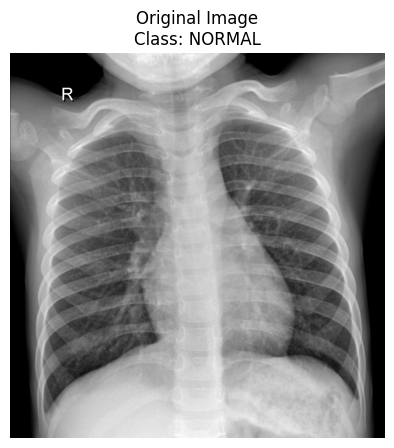

Augmented versions (n=1):


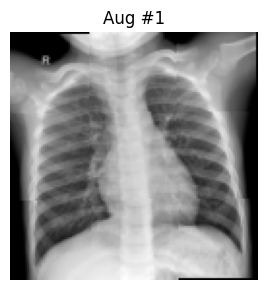

In [22]:
show_augmented_samples(clean_train_dir, train_transform_rotation, n_samples=1)

In [19]:
train_data_rotation = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_rotation)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_rotation))
train_size = len(train_data_rotation) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_rotation, val_data_rotation = random_split(train_data_rotation, [train_size, val_size])


In [20]:
train_loader_rotate =  DataLoader(
    train_data_rotation,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_rotate =  DataLoader(
    val_data_rotation,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

### 1 аугментация - изменения контрастности

In [21]:
# Преобразования для обучающего набора данных
train_transform_color = transforms.Compose([
            transforms.Resize((128, 128)),  # Изменение размера до 128x128
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),  # Преобразование в тензор
])

In [22]:
# Преобразования для обучающего набора данных
train_transform_color_224 = transforms.Compose([
            transforms.Resize((224, 224)),  # Изменение размера до 128x128
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),  # Преобразование в тензор
])


Original image: dataset/chest_xray_clean/train/PNEUMONIA/person1303_virus_2243.jpeg (Class: PNEUMONIA)


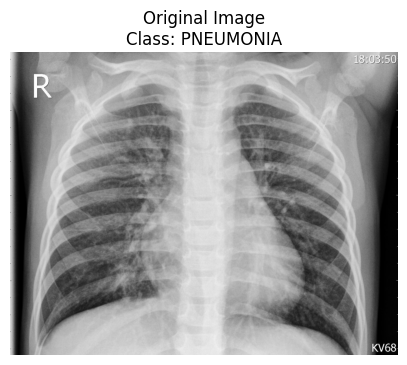

Augmented versions (n=1):


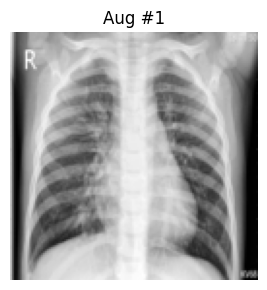

In [27]:
show_augmented_samples(clean_train_dir, train_transform_color, n_samples=1)

In [23]:
train_data_color = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_color)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_color))
train_size = len(train_data_color) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_color, val_data_color = random_split(train_data_color, [train_size, val_size])


In [24]:
train_data_color_224 = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_color_224)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_color_224))
train_size = len(train_data_color_224) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_color_224, val_data_color_224 = random_split(train_data_color_224, [train_size, val_size])


In [25]:
train_loader_color =  DataLoader(
    train_data_color,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_color =  DataLoader(
    val_data_color,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [26]:
train_loader_color_224 =  DataLoader(
    train_data_color_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_color_224 =  DataLoader(
    val_data_color_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

### 1 аугментация - сдвиг

In [27]:
# Преобразования для обучающего набора данных
train_transform_affine = transforms.Compose([
            transforms.Resize((128, 128)),  # Изменение размера до 128x128
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
            transforms.ToTensor(),  # Преобразование в тензор
])

In [28]:
# Преобразования для обучающего набора данных
train_transform_affine_224 = transforms.Compose([
            transforms.Resize((224, 224)),  # Изменение размера до 128x128
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
            transforms.ToTensor(),  # Преобразование в тензор
])


Original image: dataset/chest_xray_clean/train/PNEUMONIA/person487_bacteria_2060.jpeg (Class: PNEUMONIA)


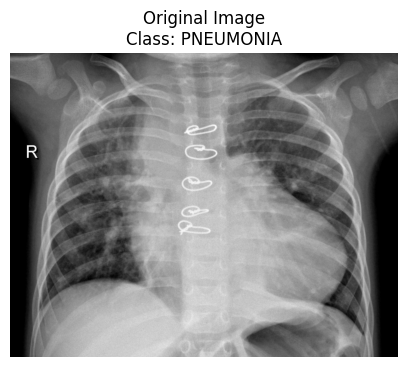

Augmented versions (n=1):


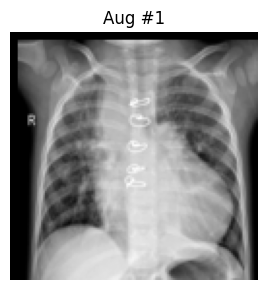

In [34]:
show_augmented_samples(clean_train_dir, train_transform_affine, n_samples=1)

In [29]:
train_data_affine = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_affine)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_affine))
train_size = len(train_data_affine) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_affine, val_data_affine = random_split(train_data_affine, [train_size, val_size])


In [30]:
train_data_affine_224 = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_affine_224)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_affine_224))
train_size = len(train_data_affine_224) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_affine_224, val_data_affine_224 = random_split(train_data_affine_224, [train_size, val_size])


In [31]:
train_loader_affine =  DataLoader(
    train_data_affine,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_affine =  DataLoader(
    val_data_affine,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [32]:
train_loader_affine_224 =  DataLoader(
    train_data_affine_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_affine_224 =  DataLoader(
    val_data_affine_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

### 1 аугментация - шум

In [33]:
# Преобразования для обучающего набора данных
train_transform_blur = transforms.Compose([
            transforms.Resize((128, 128)),  # Изменение размера до 128x128
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor(),  # Преобразование в тензор
])


Original image: dataset/chest_xray_clean/train/PNEUMONIA/person1810_bacteria_4664.jpeg (Class: PNEUMONIA)


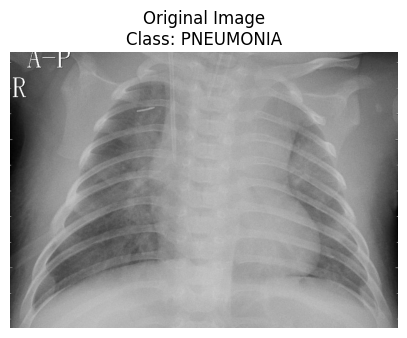

Augmented versions (n=1):


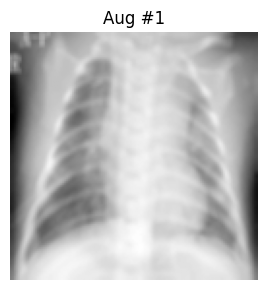

In [40]:
show_augmented_samples(clean_train_dir, train_transform_blur, n_samples=1)

In [34]:
train_data_blur = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_affine)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_blur))
train_size = len(train_data_blur) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_blur, val_data_blur = random_split(train_data_blur, [train_size, val_size])


In [35]:
train_loader_blur =  DataLoader(
    train_data_blur,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_blur =  DataLoader(
    val_data_blur,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

## 2 аугментации base+blur

In [36]:
combined_train_data = ConcatDataset([train_data_base, train_data_blur])
combined_val_data = ConcatDataset([val_data_base, val_data_blur])

In [37]:
# Создаем DataLoader'ы
train_loader_base_blur = DataLoader(
    combined_train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader_base_blur = DataLoader(
    combined_val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [78]:
print(f"Размер объединенного тренировочного набора: {len(combined_train_data)}")
print(f"Размер объединенного валидационного набора: {len(combined_val_data)}")
print(f"Размер тестового набора: {len(test_data)}")

Размер объединенного тренировочного набора: 8330
Размер объединенного валидационного набора: 2082
Размер тестового набора: 624


## 2 аугментации base+color

In [38]:
combined_train_data = ConcatDataset([train_data_base, train_data_color])
combined_val_data = ConcatDataset([val_data_base, val_data_color])

In [39]:
# Создаем DataLoader'ы
train_loader_base_color = DataLoader(
    combined_train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader_base_color = DataLoader(
    combined_val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [43]:
print(f"Размер объединенного тренировочного набора: {len(combined_train_data)}")
print(f"Размер объединенного валидационного набора: {len(combined_val_data)}")
print(f"Размер тестового набора: {len(test_data)}")

Размер объединенного тренировочного набора: 8330
Размер объединенного валидационного набора: 2082
Размер тестового набора: 624


## 3 аугментации base+blur+affine

In [40]:
combined_train_data = ConcatDataset([train_data_base, train_data_blur, train_data_affine])
combined_val_data = ConcatDataset([val_data_base, val_data_blur, val_data_affine])

In [41]:
combined_train_data_224 = ConcatDataset([train_data_base_224, train_data_blur_224, train_data_affine_224])
combined_val_data_224 = ConcatDataset([val_data_base_224, val_data_blur_224, val_data_affine_224])

NameError: name 'train_data_blur_224' is not defined

In [42]:
# Создаем DataLoader'ы
train_loader_base_blur_affine = DataLoader(
    combined_train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader_base_blur_affine = DataLoader(
    combined_val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [ ]:
print(f"Размер объединенного тренировочного набора: {len(combined_train_data)}")
print(f"Размер объединенного валидационного набора: {len(combined_val_data)}")
print(f"Размер тестового набора: {len(test_data)}")

## 3 аугментации base+blur+color

In [43]:
combined_train_data = ConcatDataset([train_data_base, train_data_color, train_data_blur])
combined_val_data = ConcatDataset([val_data_base, val_data_color, val_data_blur])

In [44]:
# Создаем DataLoader'ы
train_loader_base_blur_color = DataLoader(
    combined_train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader_base_blur_color = DataLoader(
    combined_val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [103]:
print(f"Размер объединенного тренировочного набора: {len(combined_train_data)}")
print(f"Размер объединенного валидационного набора: {len(combined_val_data)}")
print(f"Размер тестового набора: {len(test_data)}")

Размер объединенного тренировочного набора: 12495
Размер объединенного валидационного набора: 3123
Размер тестового набора: 624


## 3 аугментации base+color+affine

In [45]:
combined_train_data = ConcatDataset([train_data_base, train_data_color, train_data_affine])
combined_val_data = ConcatDataset([val_data_base, val_data_color, val_data_affine])

In [47]:
combined_train_data_224 = ConcatDataset([train_data_base_224, train_data_color_224, train_data_affine_224])
combined_val_data_224 = ConcatDataset([val_data_base_224, val_data_color_224, val_data_affine_224])

In [46]:
# Создаем DataLoader'ы
train_loader_base_color_affine = DataLoader(
    combined_train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader_base_color_affine = DataLoader(
    combined_val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [47]:
# Создаем DataLoader'ы
train_loader_base_color_affine_224 = DataLoader(
    combined_train_data_224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader_base_color_affine_224 = DataLoader(
    combined_val_data_224,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

NameError: name 'combined_train_data_224' is not defined

In [48]:
print(f"Размер объединенного тренировочного набора: {len(combined_train_data)}")
print(f"Размер объединенного валидационного набора: {len(combined_val_data)}")
print(f"Размер тестового набора: {len(test_data)}")

Размер объединенного тренировочного набора: 12495
Размер объединенного валидационного набора: 3123
Размер тестового набора: 624


# Загрузка датасета OCT

In [ ]:
clean_train_dir_oct = 'dataset_clean/OCT2017/train'
test_dir_oct ='dataset_oct/OCT2017/test'

In [ ]:
# Преобразования для обучающего набора данных
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера до 128x128
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Случайное изменение яркости, контраста, насыщенности и оттенка
    transforms.ToTensor(),  # Преобразование в тензор
])

# Преобразования для тестового набора данных
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера до 128x128
    transforms.ToTensor(),  # Преобразование в тензор
])

In [ ]:
clean_train_data_oct = datasets.ImageFolder(root=clean_train_dir_oct, transform=train_transform)
test_data_oct = datasets.ImageFolder(root=test_dir_oct, transform=test_transform)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(clean_train_data_oct))
train_size = len(clean_train_data_oct) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_oct, val_data_oct = random_split(clean_train_data_oct, [train_size, val_size])


In [ ]:
train_loader_oct =  DataLoader(
    clean_train_data_oct,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
test_loader_oct = DataLoader(
    test_data_oct,
    batch_size=batch_size,
    shuffle=False,  # Для тестовых данных перемешивание не требуется
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

val_loader_oct =  DataLoader(
    val_data_oct,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

# Устройство

In [48]:
# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Модели для классификации

## Функция для обучения модели

###train_model

In [49]:
import time
from tqdm import tqdm
import numpy as np
import torch

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, save_path="best_model.pth"):
    best_accuracy = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Для хранения времени обучения
    total_start_time = time.time()
    epoch_times = []

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch + 1}/{num_epochs}")
        print("-" * 10)

        epoch_start_time = time.time()

        # Переключение модели в режим обучения
        model.train()

        train_loss = 0
        train_correct = 0
        train_total = 0

        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(train_loader, desc="Тренировка"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            # Статистика
            train_loss += loss.item()
            train_correct += torch.sum(preds == labels.data)
            train_total += labels.size(0)

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100 * train_correct / train_total
        train_losses.append(epoch_loss)
        train_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_accuracy)

        print(f"Train loss: {epoch_loss:.4f}, train accuracy: {epoch_acc:.4f}")

        # Переключение модели в режим оценки
        model.eval()

        val_loss = 0
        val_correct = 0
        val_total = 0

        # Отключение вычисления градиентов для ускорения процесса оценки
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Валидация"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_total += labels.size(0)
                val_correct += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(test_loader)
        val_epoch_acc = 100 * val_correct / val_total

        val_losses.append(val_epoch_loss)
        val_accuracy = val_epoch_acc
        val_accuracies.append(val_accuracy)

        print(f"Val_loss: {val_epoch_loss:.4f}, Val_accuracy: {val_accuracy:.4f}")

        # Сохранение модели, если точность улучшилась
        if val_epoch_acc > best_accuracy:
            best_accuracy = val_epoch_acc
            torch.save(model.state_dict(), save_path)
            print(f"Модель сохранена с точностью {best_accuracy:.4f}")

        # Вывод текущих метрик после каждой эпохи
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        remaining_time = (num_epochs - epoch - 1) * np.mean(epoch_times) if epoch > 0 else 0

        print(f'Epoch {epoch:2d}  |  Time: {epoch_time:.2f}s  |  Est. remaining: {remaining_time:.2f}s')
        print(f'Train Loss: {train_losses[-1]:.6f}  |  Val Loss: {val_losses[-1]:.6f}')
        print(f'Train Accuracy: {train_accuracy:.2f}%  |  Val Accuracy: {val_accuracy:.2f}%')

        # Преобразование тензоров в массивы NumPy
        train_acc_np = np.array([tensor.cpu().numpy() for tensor in train_accuracies])
        val_acc_np = np.array([tensor.cpu().numpy() for tensor in val_accuracies])

    total_time = time.time() - total_start_time
    print("-" * 50)
    print(f"Обучение завершено за {total_time:.2f} секунд")
    print(f"Среднее время эпохи: {np.mean(epoch_times):.2f}s")
    print(f"Лучшая точность на валидации: {best_accuracy:.4f}")

    return model, train_losses, train_acc_np, val_losses, val_acc_np

## Функции для оценки модели

In [50]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

classes = ['NORMAL', 'PNEUMONIA']

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Для хранения вероятностей классов

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Вычисление метрик
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Вывод итоговых метрик в красивом формате
    print("\n" + "="*50)
    print("ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:")
    print("="*50)
    print(f"{'Accuracy:':<15} {accuracy:.4f}")
    print(f"{'Precision:':<15} {precision:.4f}")
    print(f"{'Recall:':<15} {recall:.4f}")
    print(f"{'F1-score:':<15} {f1:.4f}")
    print("="*50 + "\n")

    # Подробный отчет о классификации
    print("ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    print("\nМАТРИЦА ОШИБОК:")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Визуализация ROC-кривой
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc="lower right")
    plt.show()

In [77]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

classes = ['NORMAL', 'PNEUMONIA']

# Оценка модели на тестовых данных с визуализацией
def evaluate_model_old(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Для хранения вероятностей классов

    with torch.no_grad():
        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса ('PNEUMONIA')

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Вычисление метрик
    acc = accuracy_score(y_true, y_pred)

    # Вывод отчета
    print("Отчет о классификации:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Accuracy
    print(f"Accuracy: {acc:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    print("Матрица ошибок:")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Визуализация ROC-кривой
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайных предсказаний
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc="lower right")
    plt.show()


In [52]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

classes = ['NORMAL', 'PNEUMONIA']

# Оценка модели на тестовых данных с визуализацией
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Для хранения вероятностей классов

    with torch.no_grad():
        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса ('PNEUMONIA')

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Вычисление метрик
    acc = accuracy_score(y_true, y_pred)

    # Вывод отчета
    print("Отчет о классификации:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Accuracy
    print(f"Accuracy: {acc:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    print("Матрица ошибок:")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Визуализация ROC-кривой
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайных предсказаний
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc="lower right")
    plt.show()


In [53]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

classes = ['NORMAL', 'PNEUMONIA']

# Оценка модели на тестовых данных с визуализацией
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Для хранения вероятностей классов

    with torch.no_grad():
        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса ('PNEUMONIA')

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Вычисление метрик
    acc = accuracy_score(y_true, y_pred)

    # Вывод отчета
    print("Отчет о классификации:")
    print()
    print(classification_report(y_true, y_pred, target_names=classes))

    # Accuracy
    print(f"Accuracy: {acc:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    print("Матрица ошибок:")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Визуализация ROC-кривой
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайных предсказаний
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc="lower right")
    plt.show()


# ResNet

##ResNet - без аугментаций

In [51]:
# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [53]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [57]:
# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_base, val_loader_base, criterion, optimizer, num_epochs=5, save_path="best_model.pth")

Эпоха 1/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.68it/s]


Train loss: 0.1209, train accuracy: 95.4862


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.77it/s]


Val_loss: 0.0856, Val_accuracy: 96.5418
Модель сохранена с точностью 96.5418
Epoch  0  |  Time: 18.97s  |  Est. remaining: 0.00s
Train Loss: 0.120871  |  Val Loss: 0.085572
Train Accuracy: 95.49%  |  Val Accuracy: 96.54%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.79it/s]


Train loss: 0.0512, train accuracy: 98.1032


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.58it/s]


Val_loss: 0.1506, Val_accuracy: 94.3324
Epoch  1  |  Time: 18.76s  |  Est. remaining: 56.59s
Train Loss: 0.051152  |  Val Loss: 0.150587
Train Accuracy: 98.10%  |  Val Accuracy: 94.33%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.67it/s]


Train loss: 0.0504, train accuracy: 98.1993


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.23it/s]


Val_loss: 0.0595, Val_accuracy: 97.6945
Модель сохранена с точностью 97.6945
Epoch  2  |  Time: 19.22s  |  Est. remaining: 37.97s
Train Loss: 0.050395  |  Val Loss: 0.059467
Train Accuracy: 98.20%  |  Val Accuracy: 97.69%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.81it/s]


Train loss: 0.0241, train accuracy: 99.2077


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.73it/s]


Val_loss: 0.0400, Val_accuracy: 98.2709
Модель сохранена с точностью 98.2709
Epoch  3  |  Time: 18.75s  |  Est. remaining: 18.93s
Train Loss: 0.024119  |  Val Loss: 0.040014
Train Accuracy: 99.21%  |  Val Accuracy: 98.27%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.69it/s]


Train loss: 0.0225, train accuracy: 99.1837


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.75it/s]

Val_loss: 0.0496, Val_accuracy: 98.2709
Epoch  4  |  Time: 18.85s  |  Est. remaining: 0.00s
Train Loss: 0.022539  |  Val Loss: 0.049642
Train Accuracy: 99.18%  |  Val Accuracy: 98.27%
--------------------------------------------------
Обучение завершено за 94.55 секунд
Среднее время эпохи: 18.91s
Лучшая точность на валидации: 98.2709


Тестирование: 100%|██████████| 33/33 [00:04<00:00,  6.72it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9827
Precision:      0.9848
Recall:         0.9924
F1-score:       0.9886

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9759    0.9529    0.9643       255
   PNEUMONIA     0.9848    0.9924    0.9886       786

    accuracy                         0.9827      1041
   macro avg     0.9804    0.9727    0.9764      1041
weighted avg     0.9827    0.9827    0.9826      1041


МАТРИЦА ОШИБОК:
[[243  12]
 [  6 780]]


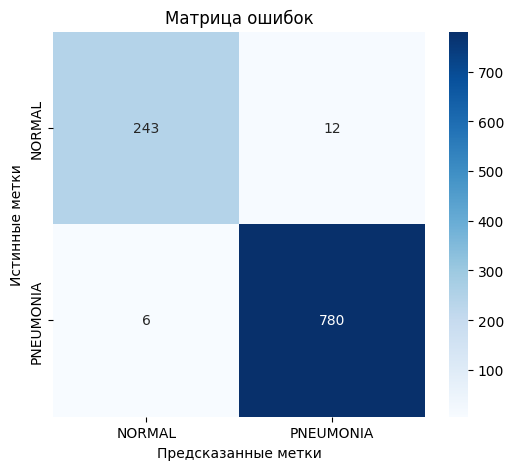

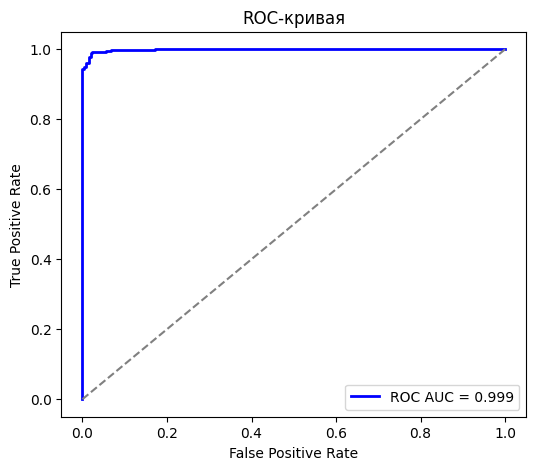

In [54]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base)

In [128]:
import json

# Создаем список словарей с метриками
model_metrics = [
    {
        "model_name": "resnet_base",
        "metrics": {
            "Accuracy": 0.9827,
            "Precision": 0.9848,
            "Recall": 0.9924,
            "F1-score": 0.9886
        }
    }
]

In [ ]:
# Создаем словарь для хранения результатов моделей
models_accuracy = {}

# Добавляем результаты в словарь
models_accuracy['model_resnet_base'] = 0.9827


Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.74it/s]

Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.98      0.95      0.96       255
   PNEUMONIA       0.98      0.99      0.99       786

    accuracy                           0.98      1041
   macro avg       0.98      0.97      0.98      1041
weighted avg       0.98      0.98      0.98      1041

Accuracy: 0.9827
Матрица ошибок:
[[243  12]
 [  6 780]]


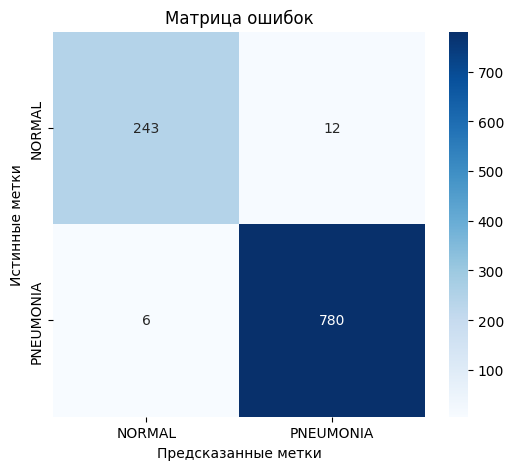

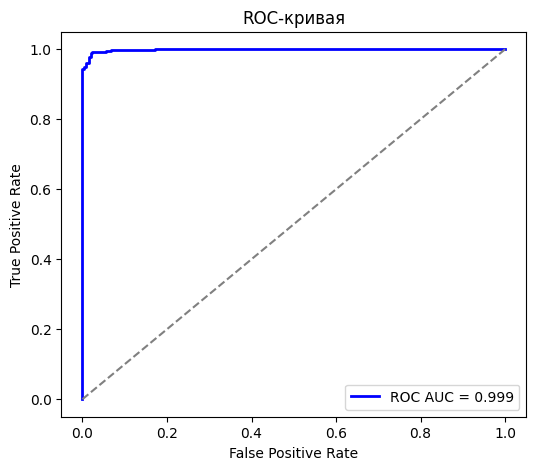

In [58]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base)

Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.51it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.98      0.95      0.96       255
   PNEUMONIA       0.98      0.99      0.99       786

    accuracy                           0.98      1041
   macro avg       0.98      0.97      0.98      1041
weighted avg       0.98      0.98      0.98      1041

Accuracy: 0.9827
Матрица ошибок:
[[243  12]
 [  6 780]]


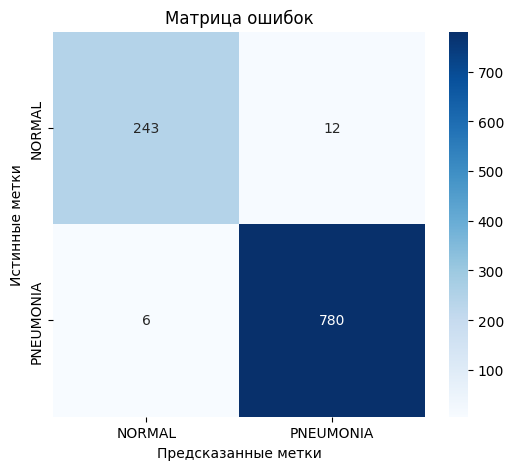

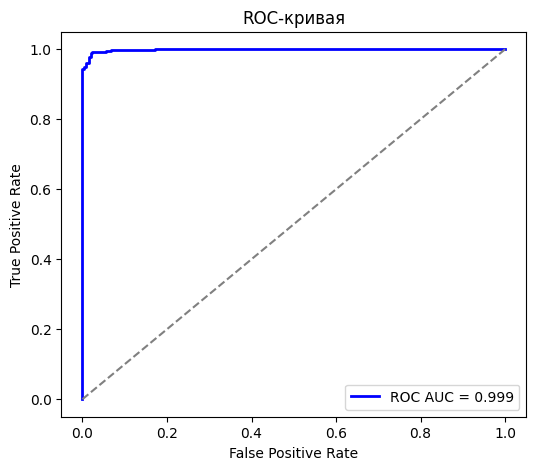

In [60]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base)

In [61]:
# Создаем словарь для хранения результатов моделей
models_accuracy = {}

# Добавляем результаты в словарь
models_accuracy['model_resnet_base'] = 0.9827


##ResNet - аугментация rotation

In [61]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_rotate, val_loader_rotate, criterion, optimizer, num_epochs=5, save_path="best_model_rotate.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.58it/s]


Train loss: 0.1329, train accuracy: 95.0060


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.53it/s]


Val_loss: 0.1852, Val_accuracy: 93.9481
Модель сохранена с точностью 93.9481
Epoch  0  |  Time: 19.31s  |  Est. remaining: 0.00s
Train Loss: 0.132934  |  Val Loss: 0.185229
Train Accuracy: 95.01%  |  Val Accuracy: 93.95%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.85it/s]


Train loss: 0.0830, train accuracy: 97.3829


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.41it/s]


Val_loss: 0.0709, Val_accuracy: 97.5985
Модель сохранена с точностью 97.5985
Epoch  1  |  Time: 18.83s  |  Est. remaining: 57.20s
Train Loss: 0.083048  |  Val Loss: 0.070911
Train Accuracy: 97.38%  |  Val Accuracy: 97.60%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.74it/s]


Train loss: 0.0930, train accuracy: 97.1188


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.60it/s]


Val_loss: 1.0685, Val_accuracy: 77.7137
Epoch  2  |  Time: 18.83s  |  Est. remaining: 37.97s
Train Loss: 0.093032  |  Val Loss: 1.068541
Train Accuracy: 97.12%  |  Val Accuracy: 77.71%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.68it/s]


Train loss: 0.0587, train accuracy: 97.5990


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.74it/s]


Val_loss: 0.0889, Val_accuracy: 96.4457
Epoch  3  |  Time: 18.88s  |  Est. remaining: 18.96s
Train Loss: 0.058710  |  Val Loss: 0.088900
Train Accuracy: 97.60%  |  Val Accuracy: 96.45%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.83it/s]


Train loss: 0.0552, train accuracy: 98.2233


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.40it/s]

Val_loss: 0.0686, Val_accuracy: 97.4063
Epoch  4  |  Time: 18.77s  |  Est. remaining: 0.00s
Train Loss: 0.055187  |  Val Loss: 0.068577
Train Accuracy: 98.22%  |  Val Accuracy: 97.41%
--------------------------------------------------
Обучение завершено за 94.61 секунд
Среднее время эпохи: 18.92s
Лучшая точность на валидации: 97.5985


Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.33it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9760
Precision:      0.9935
Recall:         0.9745
F1-score:       0.9839

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9265    0.9805    0.9527       257
   PNEUMONIA     0.9935    0.9745    0.9839       784

    accuracy                         0.9760      1041
   macro avg     0.9600    0.9775    0.9683      1041
weighted avg     0.9770    0.9760    0.9762      1041


МАТРИЦА ОШИБОК:
[[252   5]
 [ 20 764]]


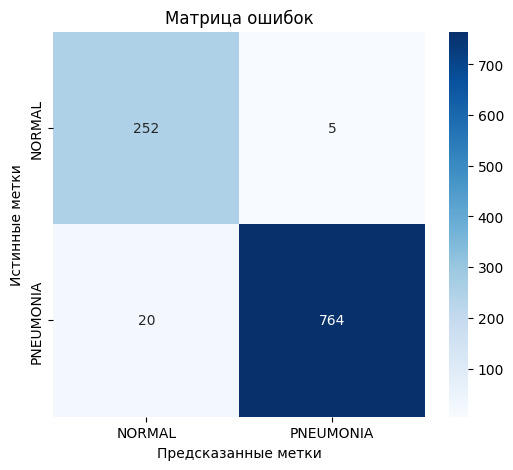

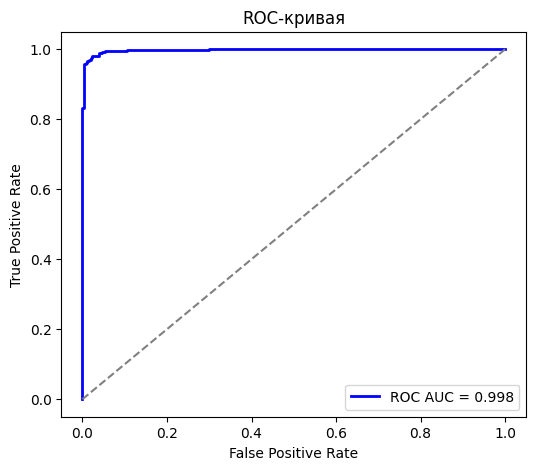

In [62]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_rotate.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_rotate)

In [129]:
# Добавляем данные для resnet_rotate
model_metrics.append(
    {
        "model_name": "resnet_rotate",
        "metrics": {
            "Accuracy": 0.9827,
            "Precision": 0.9848,
            "Recall": 0.9924,
            "F1-score": 0.9886
        }
    }
)

Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.34it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       260
   PNEUMONIA       0.98      0.98      0.98       781

    accuracy                           0.98      1041
   macro avg       0.97      0.97      0.97      1041
weighted avg       0.98      0.98      0.98      1041

Accuracy: 0.9750
Матрица ошибок:
[[247  13]
 [ 13 768]]


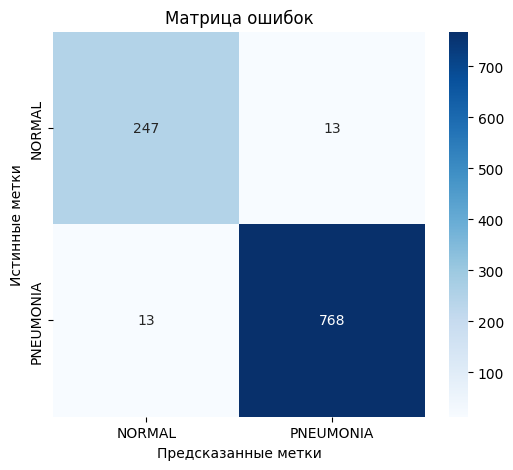

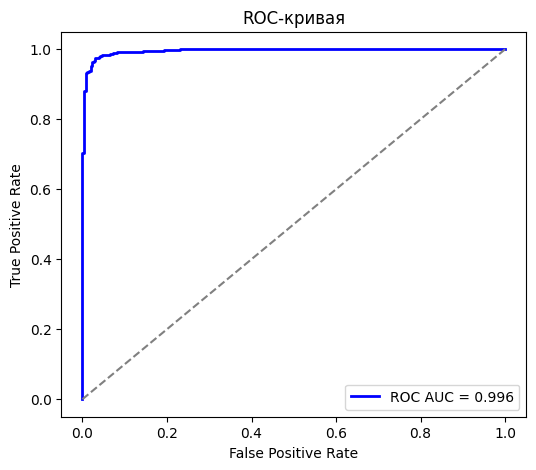

In [63]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_rotate.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_rotate)

In [64]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_rotate'] = 0.9750


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975}


##ResNet - аугментация color

In [64]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_color, val_loader_color, criterion, optimizer, num_epochs=5, save_path="best_model_color.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.53it/s]


Train loss: 0.1356, train accuracy: 95.1261


Валидация: 100%|██████████| 33/33 [00:04<00:00,  7.82it/s]


Val_loss: 0.0805, Val_accuracy: 96.5418
Модель сохранена с точностью 96.5418
Epoch  0  |  Time: 19.66s  |  Est. remaining: 0.00s
Train Loss: 0.135645  |  Val Loss: 0.080538
Train Accuracy: 95.13%  |  Val Accuracy: 96.54%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.48it/s]


Train loss: 0.0607, train accuracy: 97.6471


Валидация: 100%|██████████| 33/33 [00:04<00:00,  7.96it/s]


Val_loss: 0.0392, Val_accuracy: 99.1354
Модель сохранена с точностью 99.1354
Epoch  1  |  Time: 19.70s  |  Est. remaining: 59.04s
Train Loss: 0.060739  |  Val Loss: 0.039240
Train Accuracy: 97.65%  |  Val Accuracy: 99.14%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.32it/s]


Train loss: 0.0519, train accuracy: 98.3433


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.31it/s]


Val_loss: 0.0522, Val_accuracy: 98.0788
Epoch  2  |  Time: 19.73s  |  Est. remaining: 39.39s
Train Loss: 0.051851  |  Val Loss: 0.052190
Train Accuracy: 98.34%  |  Val Accuracy: 98.08%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.33it/s]


Train loss: 0.0638, train accuracy: 97.6951


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.08it/s]


Val_loss: 0.1688, Val_accuracy: 94.0442
Epoch  3  |  Time: 19.81s  |  Est. remaining: 19.73s
Train Loss: 0.063798  |  Val Loss: 0.168796
Train Accuracy: 97.70%  |  Val Accuracy: 94.04%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.51it/s]


Train loss: 0.0198, train accuracy: 99.3037


Валидация: 100%|██████████| 33/33 [00:03<00:00,  8.33it/s]

Val_loss: 0.0616, Val_accuracy: 97.9827
Epoch  4  |  Time: 19.36s  |  Est. remaining: 0.00s
Train Loss: 0.019774  |  Val Loss: 0.061623
Train Accuracy: 99.30%  |  Val Accuracy: 97.98%
--------------------------------------------------
Обучение завершено за 98.27 секунд
Среднее время эпохи: 19.65s
Лучшая точность на валидации: 99.1354


Тестирование: 100%|██████████| 33/33 [00:04<00:00,  7.93it/s]


ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9914
Precision:      0.9923
Recall:         0.9962
F1-score:       0.9942

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9883    0.9769    0.9826       260
   PNEUMONIA     0.9923    0.9962    0.9942       781

    accuracy                         0.9914      1041
   macro avg     0.9903    0.9865    0.9884      1041
weighted avg     0.9913    0.9914    0.9913      1041


МАТРИЦА ОШИБОК:
[[254   6]
 [  3 778]]


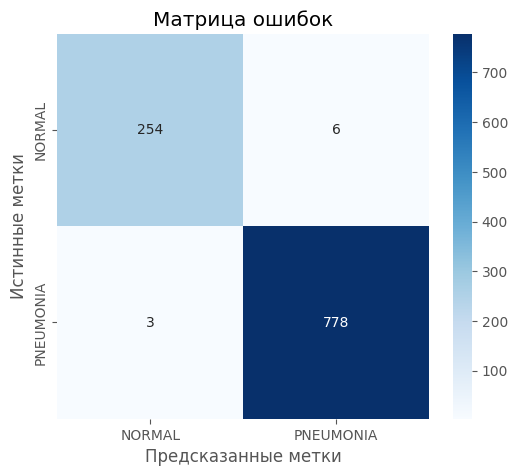

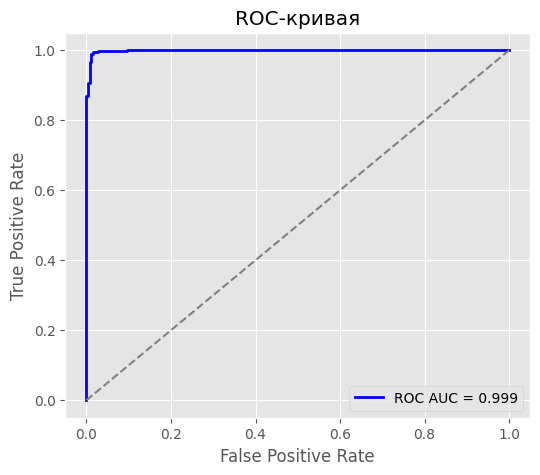

In [130]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_color)

In [132]:
model_metrics.append(
    {
        "model_name": "resnet_color",
        "metrics": {
            "Accuracy": 0.9914,
            "Precision": 0.9923,
            "Recall": 0.9962,
            "F1-score": 0.9942
        }
    }
)


Тестирование: 100%|██████████| 33/33 [00:04<00:00,  7.65it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.94      1.00      0.97       295
   PNEUMONIA       1.00      0.97      0.99       746

    accuracy                           0.98      1041
   macro avg       0.97      0.99      0.98      1041
weighted avg       0.98      0.98      0.98      1041

Accuracy: 0.9817
Матрица ошибок:
[[295   0]
 [ 19 727]]


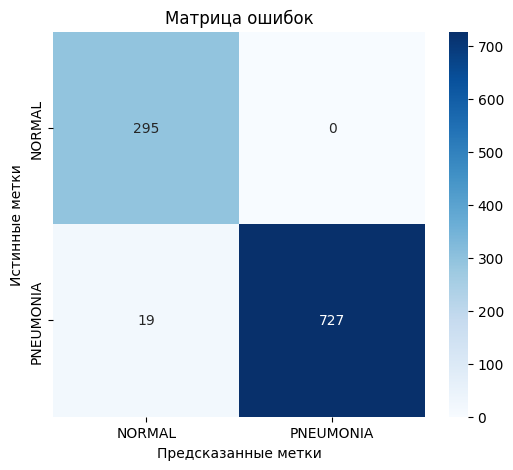

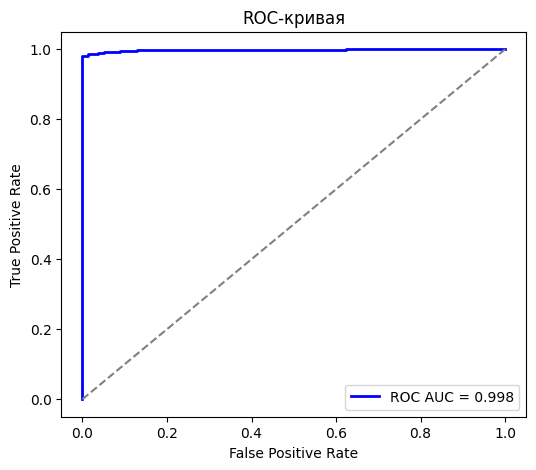

In [66]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_color)

In [67]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_color'] = 0.9817


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817}


##ResNet - аугментация affine

In [67]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_affine, val_loader_affine, criterion, optimizer, num_epochs=5, save_path="best_model_affine.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.76it/s]


Train loss: 0.1882, train accuracy: 93.7335


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.21it/s]


Val_loss: 0.0673, Val_accuracy: 97.5024
Модель сохранена с точностью 97.5024
Epoch  0  |  Time: 19.04s  |  Est. remaining: 0.00s
Train Loss: 0.188158  |  Val Loss: 0.067324
Train Accuracy: 93.73%  |  Val Accuracy: 97.50%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.78it/s]


Train loss: 0.0781, train accuracy: 97.2629


Валидация: 100%|██████████| 33/33 [00:04<00:00,  7.99it/s]


Val_loss: 0.0650, Val_accuracy: 97.4063
Epoch  1  |  Time: 19.07s  |  Est. remaining: 57.16s
Train Loss: 0.078062  |  Val Loss: 0.065010
Train Accuracy: 97.26%  |  Val Accuracy: 97.41%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.71it/s]


Train loss: 0.0594, train accuracy: 97.9352


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.19it/s]


Val_loss: 0.1464, Val_accuracy: 94.2363
Epoch  2  |  Time: 19.08s  |  Est. remaining: 38.12s
Train Loss: 0.059436  |  Val Loss: 0.146408
Train Accuracy: 97.94%  |  Val Accuracy: 94.24%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.74it/s]


Train loss: 0.0542, train accuracy: 98.0552


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.02it/s]


Val_loss: 0.0727, Val_accuracy: 97.0221
Epoch  3  |  Time: 19.11s  |  Est. remaining: 19.07s
Train Loss: 0.054193  |  Val Loss: 0.072730
Train Accuracy: 98.06%  |  Val Accuracy: 97.02%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.72it/s]


Train loss: 0.0442, train accuracy: 98.1032


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.06it/s]

Val_loss: 0.0609, Val_accuracy: 97.3103
Epoch  4  |  Time: 19.12s  |  Est. remaining: 0.00s
Train Loss: 0.044158  |  Val Loss: 0.060884
Train Accuracy: 98.10%  |  Val Accuracy: 97.31%
--------------------------------------------------
Обучение завершено за 95.41 секунд
Среднее время эпохи: 19.08s
Лучшая точность на валидации: 97.5024


Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.30it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9750
Precision:      0.9832
Recall:         0.9832
F1-score:       0.9832

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9511    0.9511    0.9511       266
   PNEUMONIA     0.9832    0.9832    0.9832       775

    accuracy                         0.9750      1041
   macro avg     0.9672    0.9672    0.9672      1041
weighted avg     0.9750    0.9750    0.9750      1041


МАТРИЦА ОШИБОК:
[[253  13]
 [ 13 762]]


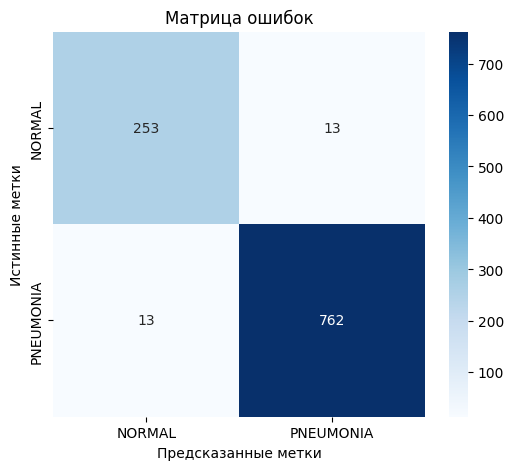

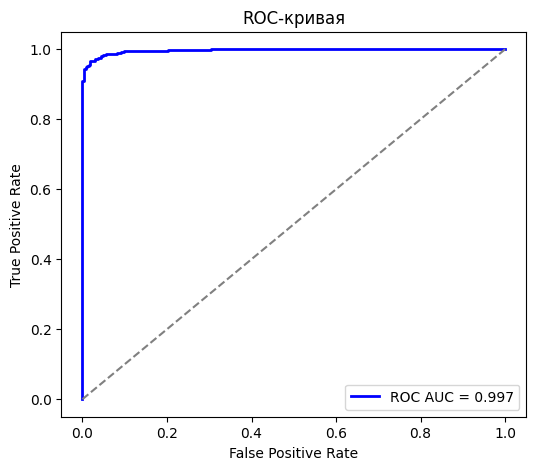

In [68]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_affine)

In [135]:
# Добавляем данные для resnet_color
model_metrics.append(
    {
        "model_name": "resnet_affine",
        "metrics": {
            "Accuracy": 0.9760,
            "Precision": 0.9832,
            "Recall": 0.9832,
            "F1-score": 0.9832}
    }
)

Тестирование: 100%|██████████| 33/33 [00:04<00:00,  8.06it/s]


ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9654
Precision:      0.9755
Recall:         0.9781
F1-score:       0.9768

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9356    0.9286    0.9321       266
   PNEUMONIA     0.9755    0.9781    0.9768       775

    accuracy                         0.9654      1041
   macro avg     0.9556    0.9533    0.9544      1041
weighted avg     0.9653    0.9654    0.9654      1041


МАТРИЦА ОШИБОК:
[[247  19]
 [ 17 758]]


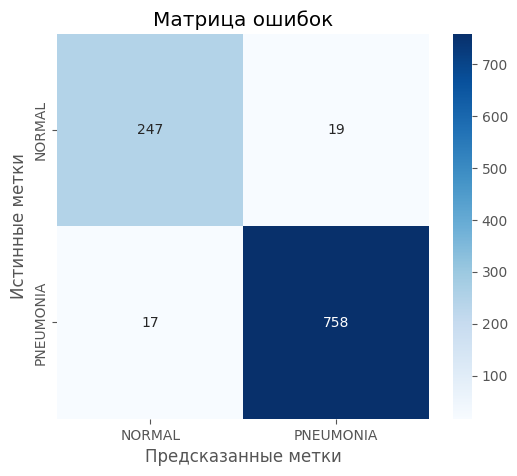

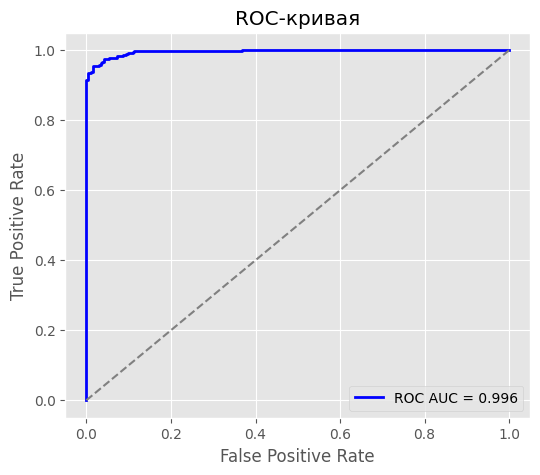

In [134]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_affine)

In [70]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_affine'] = 0.9760 #0.9673 c 0.1


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817, 'model_resnet_affine': 0.976}


## ResNet - аугментация blur

In [70]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_blur, val_loader_blur, criterion, optimizer, num_epochs=5, save_path="best_model_blur.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.60it/s]


Train loss: 0.1498, train accuracy: 94.9820


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.01it/s]


Val_loss: 0.0736, Val_accuracy: 97.0221
Модель сохранена с точностью 97.0221
Epoch  0  |  Time: 19.44s  |  Est. remaining: 0.00s
Train Loss: 0.149756  |  Val Loss: 0.073626
Train Accuracy: 94.98%  |  Val Accuracy: 97.02%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 131/131 [00:15<00:00,  8.68it/s]


Train loss: 0.0840, train accuracy: 96.7827


Валидация: 100%|██████████| 33/33 [00:04<00:00,  7.74it/s]


Val_loss: 0.0881, Val_accuracy: 96.6378
Epoch  1  |  Time: 19.36s  |  Est. remaining: 58.21s
Train Loss: 0.083971  |  Val Loss: 0.088131
Train Accuracy: 96.78%  |  Val Accuracy: 96.64%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.87it/s]


Train loss: 0.0875, train accuracy: 97.4070


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.18it/s]


Val_loss: 0.0584, Val_accuracy: 97.7906
Модель сохранена с точностью 97.7906
Epoch  2  |  Time: 18.91s  |  Est. remaining: 38.48s
Train Loss: 0.087536  |  Val Loss: 0.058356
Train Accuracy: 97.41%  |  Val Accuracy: 97.79%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.87it/s]


Train loss: 0.0552, train accuracy: 98.0792


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.07it/s]


Val_loss: 0.0887, Val_accuracy: 96.1575
Epoch  3  |  Time: 18.86s  |  Est. remaining: 19.14s
Train Loss: 0.055246  |  Val Loss: 0.088677
Train Accuracy: 98.08%  |  Val Accuracy: 96.16%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 131/131 [00:14<00:00,  8.74it/s]


Train loss: 0.0426, train accuracy: 98.4394


Валидация: 100%|██████████| 33/33 [00:04<00:00,  8.19it/s]

Val_loss: 0.2101, Val_accuracy: 92.0269
Epoch  4  |  Time: 19.03s  |  Est. remaining: 0.00s
Train Loss: 0.042592  |  Val Loss: 0.210147
Train Accuracy: 98.44%  |  Val Accuracy: 92.03%
--------------------------------------------------
Обучение завершено за 95.61 секунд
Среднее время эпохи: 19.12s
Лучшая точность на валидации: 97.7906


Тестирование: 100%|██████████| 33/33 [00:04<00:00,  7.77it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9760
Precision:      0.9947
Recall:         0.9729
F1-score:       0.9837

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9258    0.9850    0.9545       266
   PNEUMONIA     0.9947    0.9729    0.9837       775

    accuracy                         0.9760      1041
   macro avg     0.9603    0.9789    0.9691      1041
weighted avg     0.9771    0.9760    0.9762      1041


МАТРИЦА ОШИБОК:
[[262   4]
 [ 21 754]]


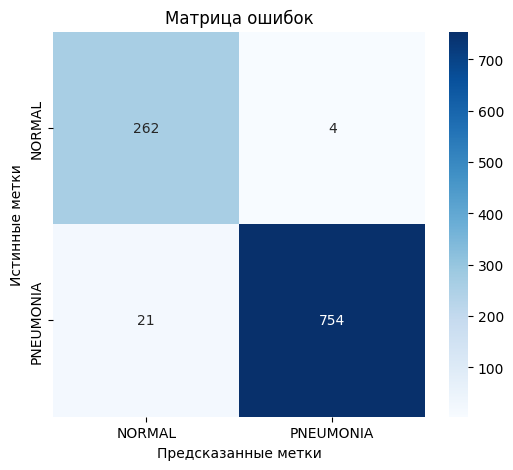

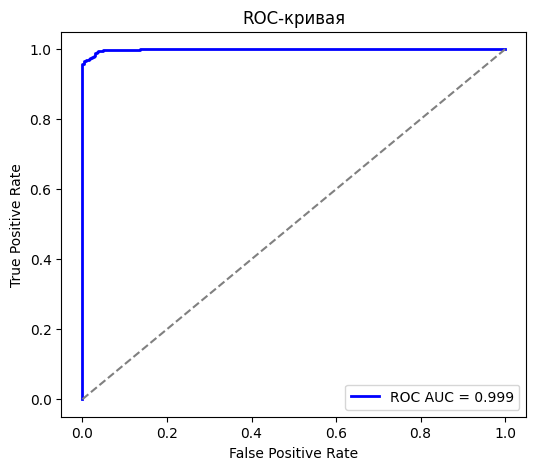

In [71]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_blur.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_affine)

In [136]:
model_metrics.append(
        {
            "model_name": "resnet_blur",
            "metrics": {
              "Accuracy": 0.9760,
              "Precision": 0.9947,
              "Recall": 0.9729,
              "F1-score": 0.9837
            }
        }
)

Тестирование: 100%|██████████| 33/33 [00:04<00:00,  8.24it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.98      0.97      0.98       279
   PNEUMONIA       0.99      0.99      0.99       762

    accuracy                           0.99      1041
   macro avg       0.99      0.98      0.99      1041
weighted avg       0.99      0.99      0.99      1041

Accuracy: 0.9885
Матрица ошибок:
[[272   7]
 [  5 757]]


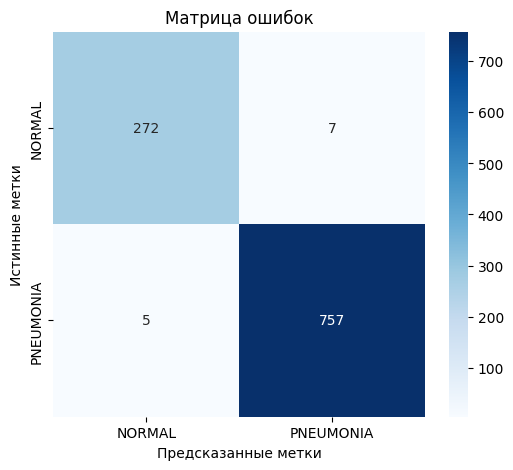

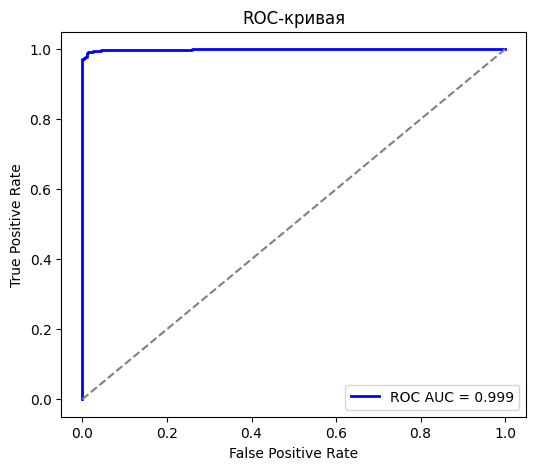

In [72]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_blur.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_affine)

In [73]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_blur'] = 0.9885


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817, 'model_resnet_affine': 0.976, 'model_resnet_blur': 0.9885}


In [ ]:
models_accuracy = {}
models_accuracy['model_resnet_blur'] = 0.9500
models_accuracy['model_resnet_base'] = 0.9789
models_accuracy['model_resnet_rotate'] = 0.9654
models_accuracy['model_resnet_color'] = 0.9827
models_accuracy['model_resnet_affine'] = 0.9808
models_accuracy['model_resnet_base_color'] = 0.9856
models_accuracy['model_resnet_base_color_affine'] = 0.9885

##Базовый и размытие

In [74]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_base_blur, val_loader_base_blur, criterion, optimizer, num_epochs=5, save_path="best_model_base_blur.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 261/261 [00:29<00:00,  8.86it/s]


Train loss: 0.1082, train accuracy: 96.1705


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.43it/s]


Val_loss: 0.0508, Val_accuracy: 98.3189
Модель сохранена с точностью 98.3189
Epoch  0  |  Time: 37.36s  |  Est. remaining: 0.00s
Train Loss: 0.108154  |  Val Loss: 0.050815
Train Accuracy: 96.17%  |  Val Accuracy: 98.32%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 261/261 [00:29<00:00,  8.89it/s]


Train loss: 0.0602, train accuracy: 97.8391


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.47it/s]


Val_loss: 0.0526, Val_accuracy: 98.0788
Epoch  1  |  Time: 37.15s  |  Est. remaining: 111.76s
Train Loss: 0.060163  |  Val Loss: 0.052553
Train Accuracy: 97.84%  |  Val Accuracy: 98.08%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 261/261 [00:29<00:00,  8.92it/s]


Train loss: 0.0577, train accuracy: 97.7911


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.51it/s]


Val_loss: 0.0357, Val_accuracy: 98.6551
Модель сохранена с точностью 98.6551
Epoch  2  |  Time: 37.13s  |  Est. remaining: 74.42s
Train Loss: 0.057734  |  Val Loss: 0.035680
Train Accuracy: 97.79%  |  Val Accuracy: 98.66%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 261/261 [00:30<00:00,  8.62it/s]


Train loss: 0.0388, train accuracy: 98.6315


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.36it/s]


Val_loss: 0.0430, Val_accuracy: 98.3670
Epoch  3  |  Time: 38.19s  |  Est. remaining: 37.46s
Train Loss: 0.038775  |  Val Loss: 0.042988
Train Accuracy: 98.63%  |  Val Accuracy: 98.37%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 261/261 [00:29<00:00,  8.81it/s]


Train loss: 0.0351, train accuracy: 98.9076


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.38it/s]

Val_loss: 0.0362, Val_accuracy: 98.4150
Epoch  4  |  Time: 37.50s  |  Est. remaining: 0.00s
Train Loss: 0.035135  |  Val Loss: 0.036244
Train Accuracy: 98.91%  |  Val Accuracy: 98.41%
--------------------------------------------------
Обучение завершено за 187.32 секунд
Среднее время эпохи: 37.46s
Лучшая точность на валидации: 98.6551


Тестирование: 100%|██████████| 66/66 [00:07<00:00,  8.40it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9861
Precision:      0.9897
Recall:         0.9916
F1-score:       0.9907

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9753    0.9698    0.9726       530
   PNEUMONIA     0.9897    0.9916    0.9907      1552

    accuracy                         0.9861      2082
   macro avg     0.9825    0.9807    0.9816      2082
weighted avg     0.9861    0.9861    0.9861      2082


МАТРИЦА ОШИБОК:
[[ 514   16]
 [  13 1539]]


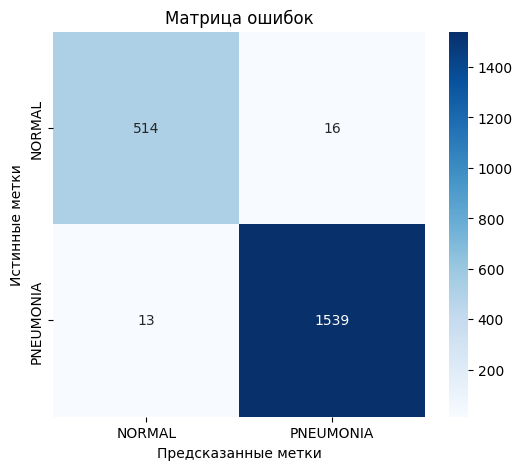

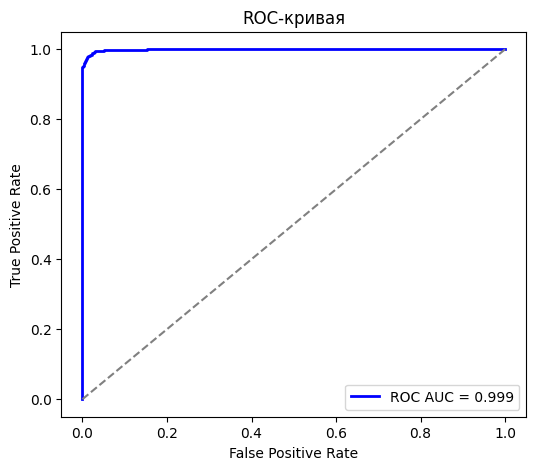

In [75]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_blur)

In [137]:
model_metrics.append(
        {
            "model_name": "resnet_base_blur",
            "metrics": {
                "Accuracy": 0.9861,
        "Precision": 0.9897,
        "Recall": 0.9916,
        "F1-score": 0.9906
            }
        }
    )

In [81]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Тестирование: 100%|██████████| 66/66 [00:07<00:00,  8.38it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9875
Precision:      0.9910
Recall:         0.9923
F1-score:       0.9916

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9773    0.9736    0.9754       530
   PNEUMONIA     0.9910    0.9923    0.9916      1552

    accuracy                         0.9875      2082
   macro avg     0.9841    0.9829    0.9835      2082
weighted avg     0.9875    0.9875    0.9875      2082


МАТРИЦА ОШИБОК:
[[ 516   14]
 [  12 1540]]


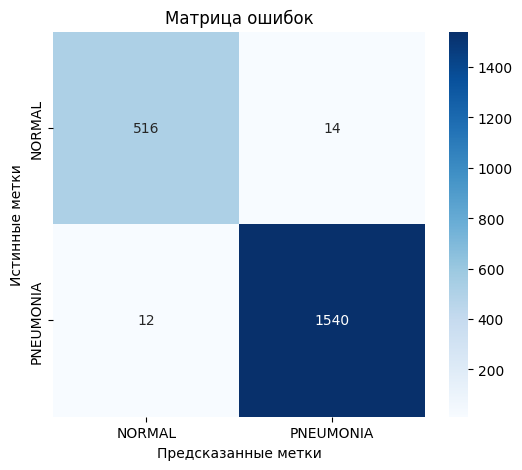

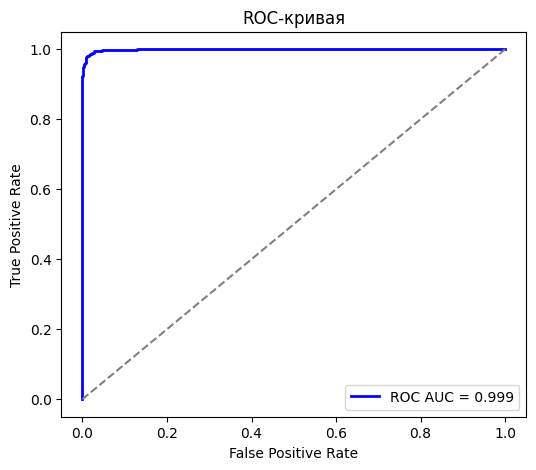

In [82]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_blur)

Тестирование: 100%|██████████| 66/66 [00:07<00:00,  8.50it/s]

Отчет о классификации:
              precision    recall  f1-score   support

      NORMAL       0.98      0.97      0.98       530
   PNEUMONIA       0.99      0.99      0.99      1552

    accuracy                           0.99      2082
   macro avg       0.98      0.98      0.98      2082
weighted avg       0.99      0.99      0.99      2082

Accuracy: 0.9875
Матрица ошибок:
[[ 515   15]
 [  11 1541]]


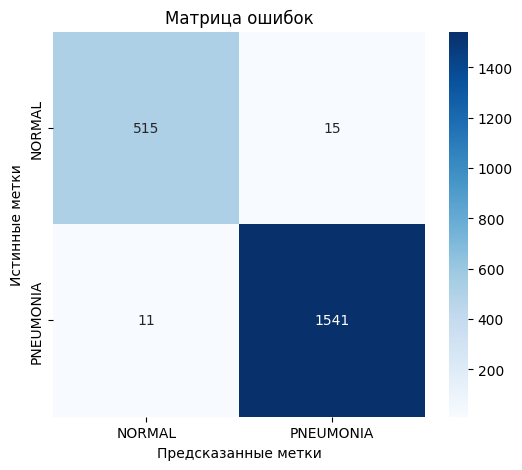

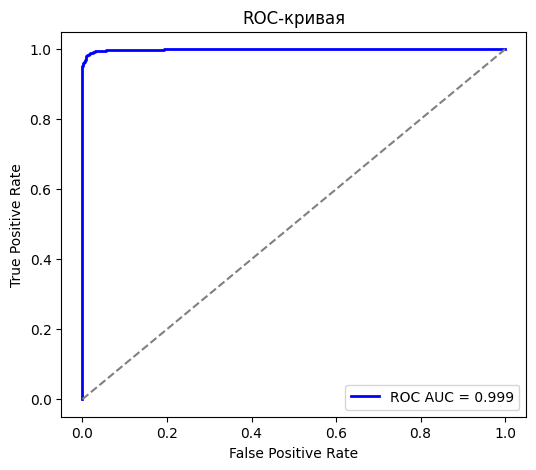

In [83]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model_old(model_resnet, val_loader_base_blur)

In [81]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_base_blur'] = 0.9875


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817, 'model_resnet_affine': 0.976, 'model_resnet_blur': 0.9885, 'model_resnet_base_blur': 0.9875}


## Базовый+яркость

In [84]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_base_color, val_loader_base_color, criterion, optimizer, num_epochs=5, save_path="best_model_base_color.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 261/261 [00:29<00:00,  8.72it/s]


Train loss: 0.0961, train accuracy: 96.6627


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.54it/s]


Val_loss: 0.0477, Val_accuracy: 97.9827
Модель сохранена с точностью 97.9827
Epoch  0  |  Time: 37.75s  |  Est. remaining: 0.00s
Train Loss: 0.096085  |  Val Loss: 0.047704
Train Accuracy: 96.66%  |  Val Accuracy: 97.98%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 261/261 [00:30<00:00,  8.65it/s]


Train loss: 0.0411, train accuracy: 98.6315


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.57it/s]


Val_loss: 0.0489, Val_accuracy: 97.9827
Epoch  1  |  Time: 37.88s  |  Est. remaining: 113.44s
Train Loss: 0.041097  |  Val Loss: 0.048902
Train Accuracy: 98.63%  |  Val Accuracy: 97.98%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 261/261 [00:29<00:00,  8.74it/s]


Train loss: 0.0369, train accuracy: 98.7395


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.61it/s]


Val_loss: 0.0238, Val_accuracy: 98.9433
Модель сохранена с точностью 98.9433
Epoch  2  |  Time: 37.62s  |  Est. remaining: 75.50s
Train Loss: 0.036857  |  Val Loss: 0.023767
Train Accuracy: 98.74%  |  Val Accuracy: 98.94%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 261/261 [00:30<00:00,  8.63it/s]


Train loss: 0.0235, train accuracy: 99.2197


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.63it/s]


Val_loss: 0.0266, Val_accuracy: 99.2315
Модель сохранена с точностью 99.2315
Epoch  3  |  Time: 37.98s  |  Est. remaining: 37.81s
Train Loss: 0.023523  |  Val Loss: 0.026578
Train Accuracy: 99.22%  |  Val Accuracy: 99.23%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 261/261 [00:29<00:00,  8.74it/s]


Train loss: 0.0233, train accuracy: 99.1116


Валидация: 100%|██████████| 66/66 [00:07<00:00,  8.59it/s]

Val_loss: 0.0154, Val_accuracy: 99.4236
Модель сохранена с точностью 99.4236
Epoch  4  |  Time: 37.66s  |  Est. remaining: 0.00s
Train Loss: 0.023331  |  Val Loss: 0.015449
Train Accuracy: 99.11%  |  Val Accuracy: 99.42%
--------------------------------------------------
Обучение завершено за 188.89 секунд
Среднее время эпохи: 37.78s
Лучшая точность на валидации: 99.4236


In [87]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Тестирование: 100%|██████████| 66/66 [00:07<00:00,  8.49it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9938
Precision:      0.9994
Recall:         0.9923
F1-score:       0.9958

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9772    0.9981    0.9875       515
   PNEUMONIA     0.9994    0.9923    0.9958      1567

    accuracy                         0.9938      2082
   macro avg     0.9883    0.9952    0.9917      2082
weighted avg     0.9939    0.9938    0.9938      2082


МАТРИЦА ОШИБОК:
[[ 514    1]
 [  12 1555]]


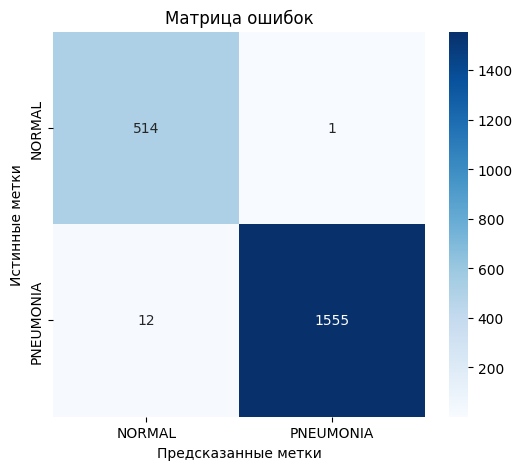

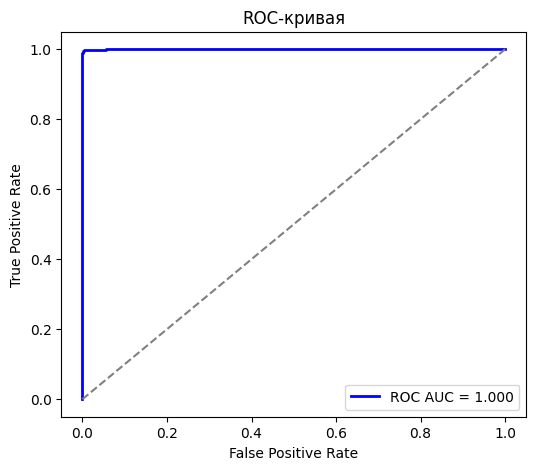

In [88]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_color)

In [138]:
model_metrics.append(
        {
            "model_name": "resnet_base_color",
            "metrics": {
                 "Accuracy": 0.9938,
            "Precision": 0.9994,
            "Recall": 0.9923,
            "F1-score": 0.9958
            }
        }
    )

Тестирование: 100%|██████████| 66/66 [00:07<00:00,  8.53it/s]

Отчет о классификации:
              precision    recall  f1-score   support

      NORMAL       0.98      1.00      0.99       515
   PNEUMONIA       1.00      0.99      1.00      1567

    accuracy                           0.99      2082
   macro avg       0.99      1.00      0.99      2082
weighted avg       0.99      0.99      0.99      2082

Accuracy: 0.9938
Матрица ошибок:
[[ 514    1]
 [  12 1555]]


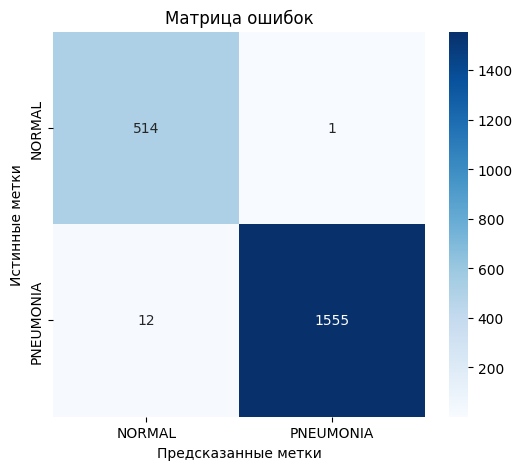

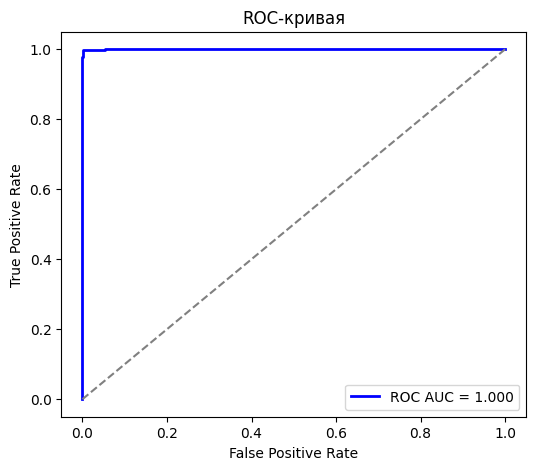

In [89]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model_old(model_resnet, val_loader_base_color)

In [ ]:
model_metrics.append(
        {
            "model_name": "resnet_base_color",
            "metrics": {
                 "Accuracy": 0.9938,
            "Precision": 0.9994,
            "Recall": 0.9923,
            "F1-score": 0.9958
            }
        }
    )

Тестирование: 100%|██████████| 66/66 [00:07<00:00,  8.46it/s]

Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.99      0.96      0.97       550
   PNEUMONIA       0.99      1.00      0.99      1532

    accuracy                           0.99      2082
   macro avg       0.99      0.98      0.98      2082
weighted avg       0.99      0.99      0.99      2082

Accuracy: 0.9856
Матрица ошибок:
[[ 527   23]
 [   7 1525]]


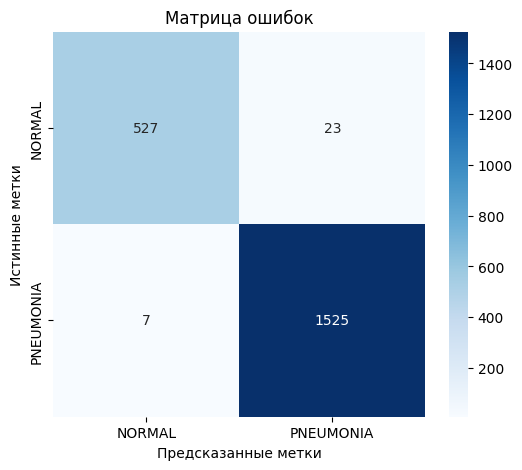

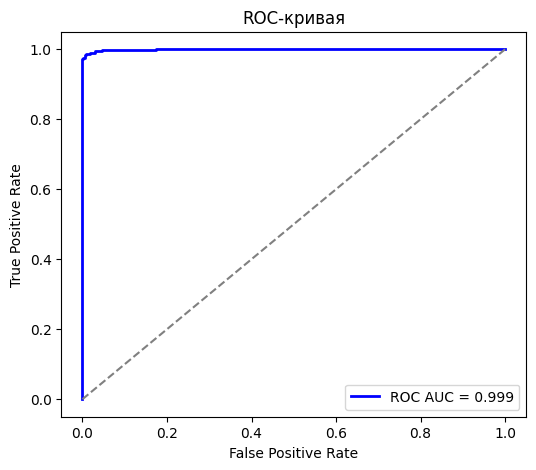

In [83]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_color)

In [84]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_base_color'] = 0.9856


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817, 'model_resnet_affine': 0.976, 'model_resnet_blur': 0.9885, 'model_resnet_base_blur': 0.9875, 'model_resnet_base_color': 0.9856}


## Базовый+размытие+сдвиг

In [91]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_base_blur_affine, val_loader_base_blur_affine, criterion, optimizer, num_epochs=5, save_path="best_model_base_blur_affine.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s]


Train loss: 0.0945, train accuracy: 96.8227


Валидация: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Val_loss: 0.0781, Val_accuracy: 96.9901
Модель сохранена с точностью 96.9901
Epoch  0  |  Time: 56.71s  |  Est. remaining: 0.00s
Train Loss: 0.094534  |  Val Loss: 0.078071
Train Accuracy: 96.82%  |  Val Accuracy: 96.99%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s]


Train loss: 0.0503, train accuracy: 98.2473


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.65it/s]


Val_loss: 0.0293, Val_accuracy: 99.0394
Модель сохранена с точностью 99.0394
Epoch  1  |  Time: 55.15s  |  Est. remaining: 167.78s
Train Loss: 0.050311  |  Val Loss: 0.029260
Train Accuracy: 98.25%  |  Val Accuracy: 99.04%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s]


Train loss: 0.0339, train accuracy: 98.8075


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.67it/s]


Val_loss: 0.0587, Val_accuracy: 98.2069
Epoch  2  |  Time: 55.41s  |  Est. remaining: 111.51s
Train Loss: 0.033867  |  Val Loss: 0.058686
Train Accuracy: 98.81%  |  Val Accuracy: 98.21%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s]


Train loss: 0.0369, train accuracy: 98.7515


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.60it/s]


Val_loss: 0.0331, Val_accuracy: 98.8152
Epoch  3  |  Time: 55.31s  |  Est. remaining: 55.64s
Train Loss: 0.036935  |  Val Loss: 0.033147
Train Accuracy: 98.75%  |  Val Accuracy: 98.82%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.85it/s]


Train loss: 0.0252, train accuracy: 99.1757


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.63it/s]

Val_loss: 0.0420, Val_accuracy: 98.1108
Epoch  4  |  Time: 55.56s  |  Est. remaining: 0.00s
Train Loss: 0.025248  |  Val Loss: 0.042015
Train Accuracy: 99.18%  |  Val Accuracy: 98.11%
--------------------------------------------------
Обучение завершено за 278.14 секунд
Среднее время эпохи: 55.63s
Лучшая точность на валидации: 99.0394


In [92]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.60it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9894
Precision:      0.9931
Recall:         0.9927
F1-score:       0.9929

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9787    0.9799    0.9793       796
   PNEUMONIA     0.9931    0.9927    0.9929      2327

    accuracy                         0.9894      3123
   macro avg     0.9859    0.9863    0.9861      3123
weighted avg     0.9894    0.9894    0.9894      3123


МАТРИЦА ОШИБОК:
[[ 780   16]
 [  17 2310]]


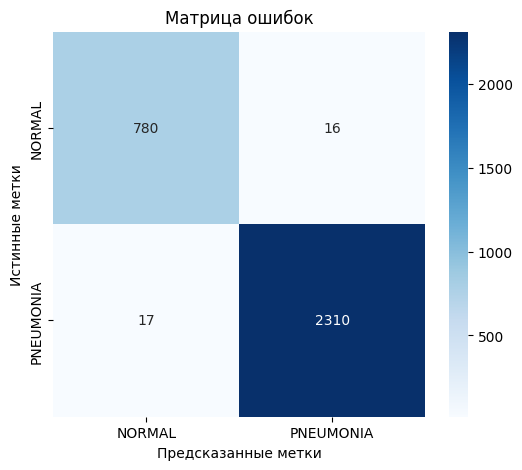

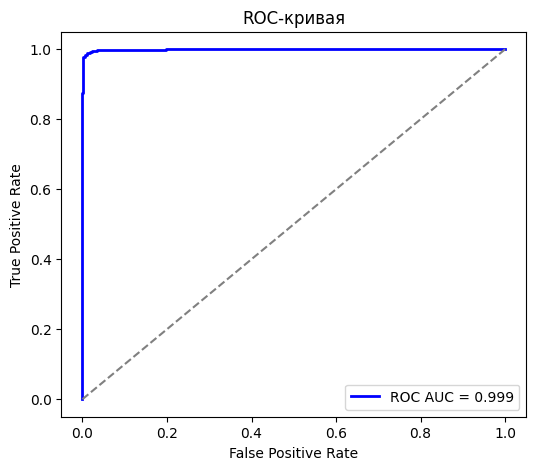

In [95]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_blur_affine)

In [139]:
model_metrics.append(
        {
            "model_name": "resnet_base_blur_affine",
            "metrics": {
                "Accuracy": 0.9894,
            "Precision": 0.9931,
            "Recall": 0.9927,
            "F1-score": 0.9929
            }
        }
    )

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.53it/s]

Отчет о классификации:
              precision    recall  f1-score   support

      NORMAL       0.98      0.98      0.98       796
   PNEUMONIA       0.99      0.99      0.99      2327

    accuracy                           0.99      3123
   macro avg       0.99      0.99      0.99      3123
weighted avg       0.99      0.99      0.99      3123

Accuracy: 0.9894
Матрица ошибок:
[[ 777   19]
 [  14 2313]]


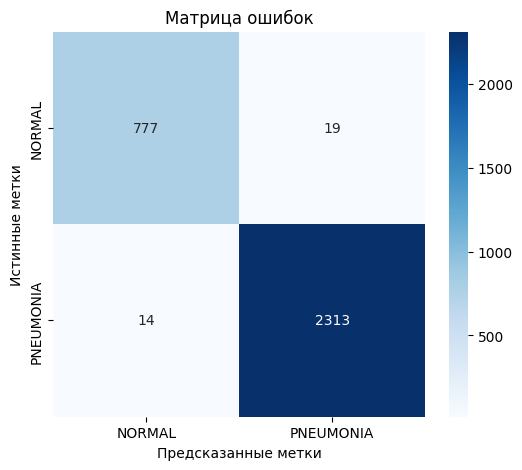

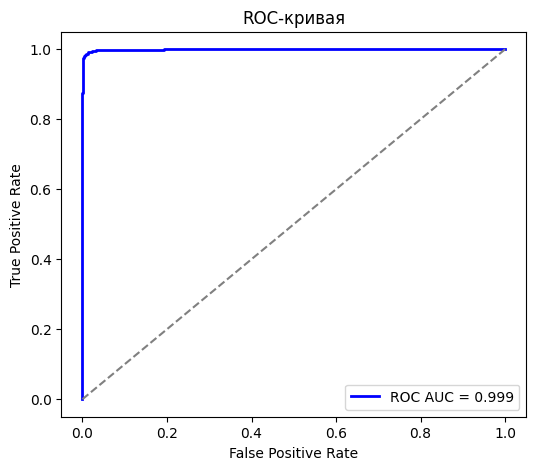

In [94]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model_old(model_resnet, val_loader_base_blur_affine)

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.55it/s]

Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.98      1.00      0.99       805
   PNEUMONIA       1.00      0.99      1.00      2318

    accuracy                           0.99      3123
   macro avg       0.99      1.00      0.99      3123
weighted avg       0.99      0.99      0.99      3123

Accuracy: 0.9949
Матрица ошибок:
[[ 805    0]
 [  16 2302]]


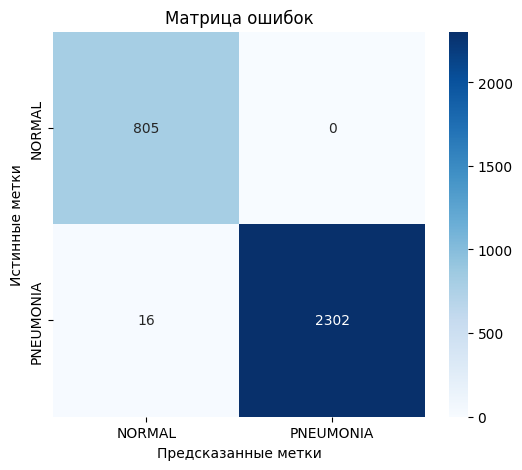

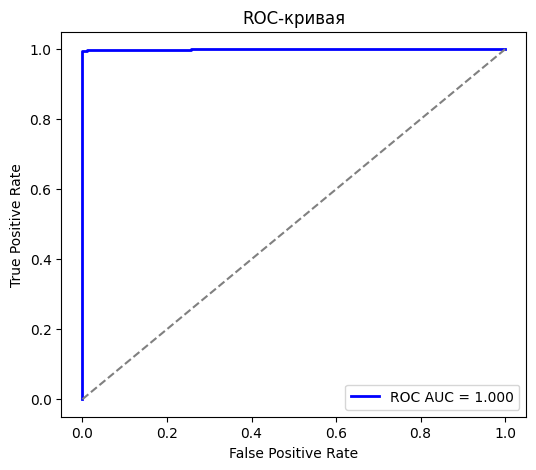

In [95]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_blur_affine)

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [96]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_base_blur_affine'] = 0.9949


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817, 'model_resnet_affine': 0.976, 'model_resnet_blur': 0.9885, 'model_resnet_base_blur': 0.9875, 'model_resnet_base_color': 0.9856, 'model_resnet_base_color_affine': 0.9933, 'model_resnet_base_blur_affine': 0.9949}


##Базовый+размытие+яркость

In [97]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_base_blur_color, val_loader_base_blur_color, criterion, optimizer, num_epochs=5, save_path="best_model_base_blur_color.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]


Train loss: 0.0816, train accuracy: 96.9908


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.44it/s]


Val_loss: 0.0428, Val_accuracy: 98.4950
Модель сохранена с точностью 98.4950
Epoch  0  |  Time: 57.61s  |  Est. remaining: 0.00s
Train Loss: 0.081558  |  Val Loss: 0.042774
Train Accuracy: 96.99%  |  Val Accuracy: 98.50%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.71it/s]


Train loss: 0.0435, train accuracy: 98.4714


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.44it/s]


Val_loss: 0.1228, Val_accuracy: 95.8373
Epoch  1  |  Time: 56.52s  |  Est. remaining: 171.21s
Train Loss: 0.043528  |  Val Loss: 0.122822
Train Accuracy: 98.47%  |  Val Accuracy: 95.84%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]


Train loss: 0.0401, train accuracy: 98.6074


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]


Val_loss: 0.1067, Val_accuracy: 96.2856
Epoch  2  |  Time: 57.06s  |  Est. remaining: 114.13s
Train Loss: 0.040114  |  Val Loss: 0.106722
Train Accuracy: 98.61%  |  Val Accuracy: 96.29%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.68it/s]


Train loss: 0.0266, train accuracy: 98.9516


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.34it/s]


Val_loss: 0.0153, Val_accuracy: 99.2956
Модель сохранена с точностью 99.2956
Epoch  3  |  Time: 56.89s  |  Est. remaining: 57.02s
Train Loss: 0.026623  |  Val Loss: 0.015292
Train Accuracy: 98.95%  |  Val Accuracy: 99.30%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.67it/s]


Train loss: 0.0260, train accuracy: 99.0956


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.52it/s]

Val_loss: 0.0138, Val_accuracy: 99.6158
Модель сохранена с точностью 99.6158
Epoch  4  |  Time: 56.69s  |  Est. remaining: 0.00s
Train Loss: 0.025994  |  Val Loss: 0.013794
Train Accuracy: 99.10%  |  Val Accuracy: 99.62%
--------------------------------------------------
Обучение завершено за 284.78 секунд
Среднее время эпохи: 56.96s
Лучшая точность на валидации: 99.6158


In [98]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9962
Precision:      0.9957
Recall:         0.9991
F1-score:       0.9974

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9974    0.9873    0.9924       790
   PNEUMONIA     0.9957    0.9991    0.9974      2333

    accuracy                         0.9962      3123
   macro avg     0.9966    0.9932    0.9949      3123
weighted avg     0.9962    0.9962    0.9962      3123


МАТРИЦА ОШИБОК:
[[ 780   10]
 [   2 2331]]


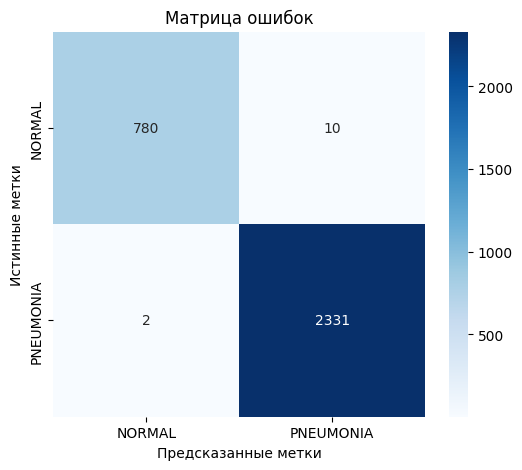

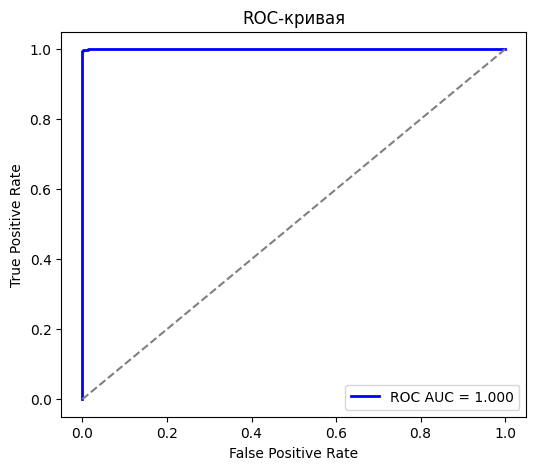

In [99]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_blur_color)

In [140]:
model_metrics.append(
        {
            "model_name": "resnet_base_blur_color",
            "metrics": {
                "Accuracy": 0.9962,
            "Precision": 0.9957,
            "Recall": 0.9991,
            "F1-score": 0.9974
            }
        }
    )

In [127]:
model_metrics=[]

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.29it/s]

Отчет о классификации:
              precision    recall  f1-score   support

      NORMAL       1.00      0.99      0.99       790
   PNEUMONIA       1.00      1.00      1.00      2333

    accuracy                           1.00      3123
   macro avg       1.00      0.99      0.99      3123
weighted avg       1.00      1.00      1.00      3123

Accuracy: 0.9962
Матрица ошибок:
[[ 781    9]
 [   3 2330]]


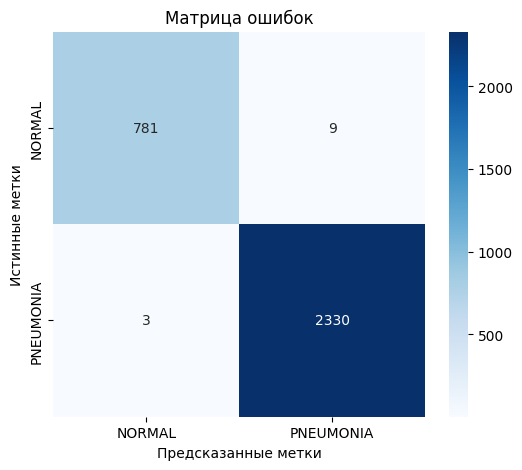

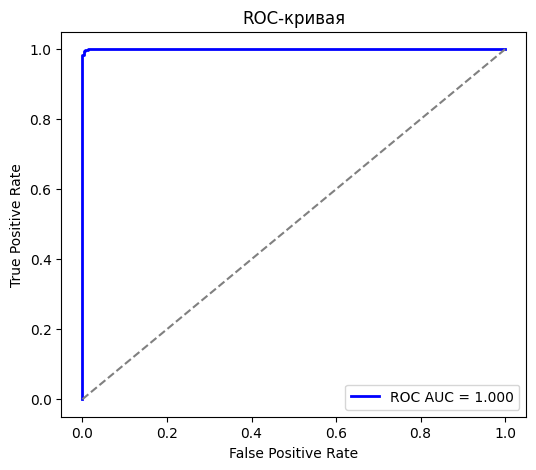

In [100]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model_old(model_resnet, val_loader_base_blur_color)

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.64it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.98      0.99      0.98       821
   PNEUMONIA       1.00      0.99      0.99      2302

    accuracy                           0.99      3123
   macro avg       0.99      0.99      0.99      3123
weighted avg       0.99      0.99      0.99      3123

Accuracy: 0.9910
Матрица ошибок:
[[ 810   11]
 [  17 2285]]


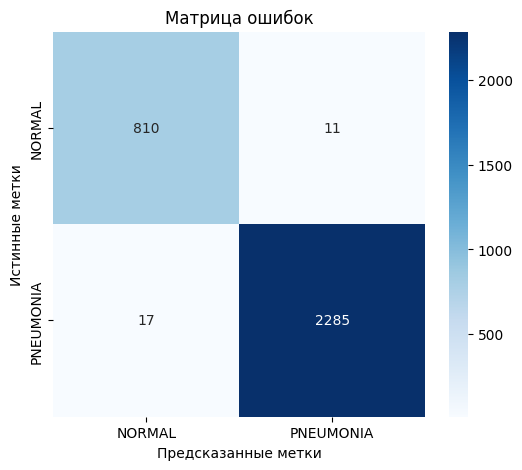

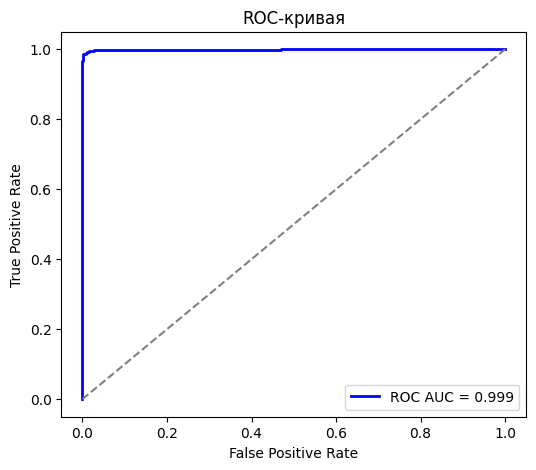

In [105]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_blur_color)

In [ ]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_blur_color.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model_old(model_resnet, val_loader_base_blur_color)

In [106]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_base_blur_color'] = 0.9910


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817, 'model_resnet_affine': 0.976, 'model_resnet_blur': 0.9885, 'model_resnet_base_blur': 0.9875, 'model_resnet_base_color': 0.9856, 'model_resnet_base_color_affine': 0.9933, 'model_resnet_base_blur_affine': 0.9949, 'model_resnet_base_blur_color': 0.991}


## Базовый+яркость+сдвиг

In [102]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_base_color_affine, val_loader_base_color_affine, criterion, optimizer, num_epochs=5, save_path="best_model_base_color_affine.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s]


Train loss: 0.0936, train accuracy: 96.7827


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.65it/s]


Val_loss: 0.2521, Val_accuracy: 92.8274
Модель сохранена с точностью 92.8274
Epoch  0  |  Time: 56.00s  |  Est. remaining: 0.00s
Train Loss: 0.093621  |  Val Loss: 0.252144
Train Accuracy: 96.78%  |  Val Accuracy: 92.83%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.85it/s]


Train loss: 0.0482, train accuracy: 98.3113


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


Val_loss: 0.0795, Val_accuracy: 96.9901
Модель сохранена с точностью 96.9901
Epoch  1  |  Time: 55.67s  |  Est. remaining: 167.50s
Train Loss: 0.048237  |  Val Loss: 0.079485
Train Accuracy: 98.31%  |  Val Accuracy: 96.99%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s]


Train loss: 0.0394, train accuracy: 98.6235


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]


Val_loss: 0.0319, Val_accuracy: 98.9113
Модель сохранена с точностью 98.9113
Epoch  2  |  Time: 56.28s  |  Est. remaining: 111.96s
Train Loss: 0.039448  |  Val Loss: 0.031901
Train Accuracy: 98.62%  |  Val Accuracy: 98.91%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.66it/s]


Train loss: 0.0283, train accuracy: 99.0396


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


Val_loss: 0.0921, Val_accuracy: 96.6699
Epoch  3  |  Time: 56.51s  |  Est. remaining: 56.11s
Train Loss: 0.028278  |  Val Loss: 0.092075
Train Accuracy: 99.04%  |  Val Accuracy: 96.67%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s]


Train loss: 0.0221, train accuracy: 99.1677


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.67it/s]

Val_loss: 0.0162, Val_accuracy: 99.2635
Модель сохранена с точностью 99.2635
Epoch  4  |  Time: 55.97s  |  Est. remaining: 0.00s
Train Loss: 0.022133  |  Val Loss: 0.016246
Train Accuracy: 99.17%  |  Val Accuracy: 99.26%
--------------------------------------------------
Обучение завершено за 280.43 секунд
Среднее время эпохи: 56.09s
Лучшая точность на валидации: 99.2635


In [103]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.62it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9942
Precision:      0.9949
Recall:         0.9975
F1-score:       0.9962

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9921    0.9843    0.9882       255
   PNEUMONIA     0.9949    0.9975    0.9962       786

    accuracy                         0.9942      1041
   macro avg     0.9935    0.9909    0.9922      1041
weighted avg     0.9942    0.9942    0.9942      1041


МАТРИЦА ОШИБОК:
[[251   4]
 [  2 784]]


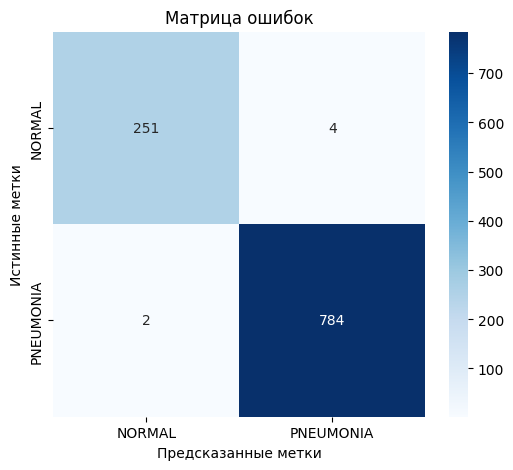

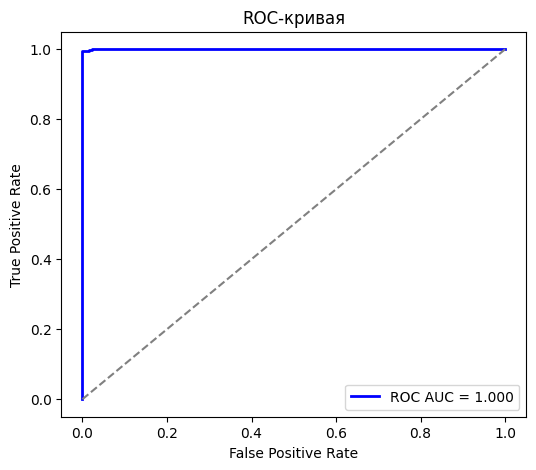

In [104]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base)

In [118]:
model_metrics

[{'model_name': 'resnet_base',
  'metrics': {'Accuracy': 0.9827,
   'Precision': 0.9848,
   'Recall': 0.9924,
   'F1-score': 0.9886}},
 {'model_name': 'resnet_rotate',
  'metrics': {'Accuracy': 0.9827,
   'Precision': 0.9848,
   'Recall': 0.9924,
   'F1-score': 0.9886}},
 {'model_name': 'resnet_color',
  'metrics': {'Accuracy': 0.9923,
   'Precision': 0.9949,
   'Recall': 0.9949,
   'F1-score': 0.9949}},
 {'model_name': 'resnet_color',
  'metrics': {'Accuracy': 0.9923,
   'Precision': 0.9949,
   'Recall': 0.9949,
   'F1-score': 0.9949}},
 {'model_name': 'resnet_blur',
  'metrics': {'Accuracy': 0.976,
   'Precision': 0.9947,
   'Recall': 0.9729,
   'F1-score': 0.9837}},
 {'model_name': 'resnet_base_blur',
  'metrics': {'Accuracy': 0.976,
   'Precision': 0.9947,
   'Recall': 0.9729,
   'F1-score': 0.9837}},
 {'model_name': 'resnet_base_color',
  'metrics': {'Accuracy': 0.9938,
   'Precision': 0.9994,
   'Recall': 0.9923,
   'F1-score': 0.9958}},
 {'model_name': 'resnet_base_blur_affine',

In [141]:
model_metrics.append(
        {
            "model_name": "resnet_base_color_affine",
            "metrics": {
                "Accuracy": 0.9942,
            "Precision": 0.9949,
            "Recall": 0.9975,
            "F1-score": 0.9962
            }
        }
    )


Тестирование: 100%|██████████| 33/33 [00:04<00:00,  8.17it/s]

Отчет о классификации:
              precision    recall  f1-score   support

      NORMAL       0.99      0.98      0.99       255
   PNEUMONIA       0.99      1.00      1.00       786

    accuracy                           0.99      1041
   macro avg       0.99      0.99      0.99      1041
weighted avg       0.99      0.99      0.99      1041

Accuracy: 0.9942
Матрица ошибок:
[[251   4]
 [  2 784]]


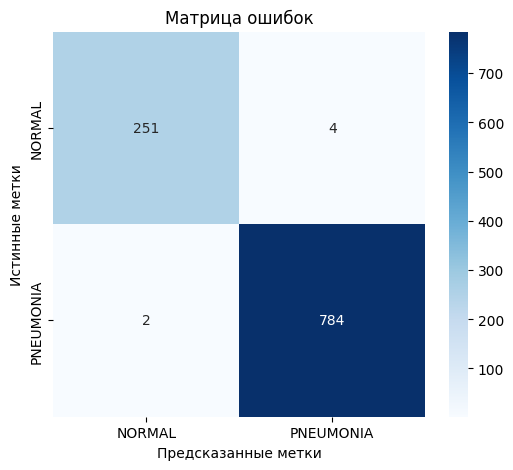

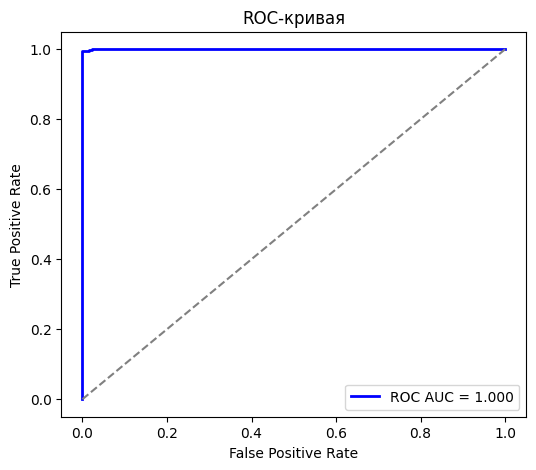

In [105]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model_old(model_resnet, val_loader_base)

Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.46it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       1.00      0.98      0.99       255
   PNEUMONIA       0.99      1.00      1.00       786

    accuracy                           0.99      1041
   macro avg       0.99      0.99      0.99      1041
weighted avg       0.99      0.99      0.99      1041

Accuracy: 0.9933
Матрица ошибок:
[[249   6]
 [  1 785]]


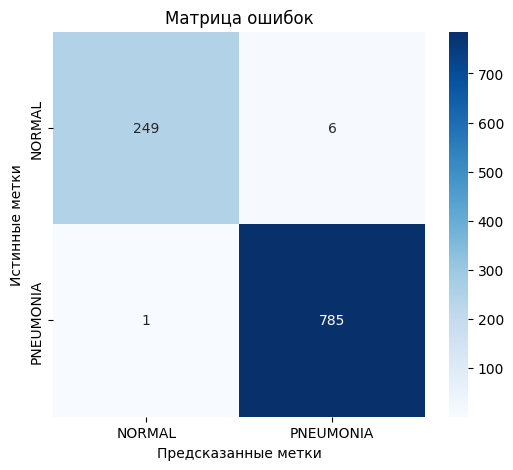

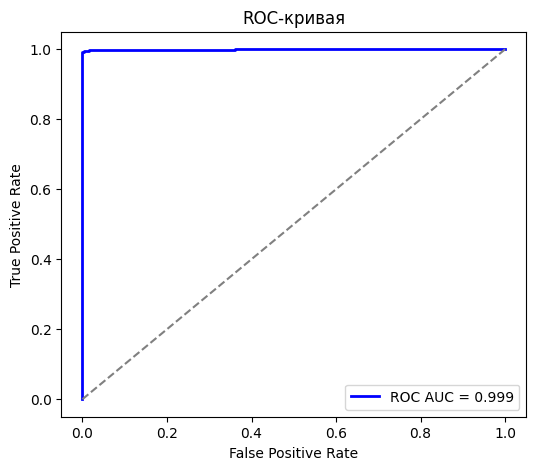

In [87]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base)

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.71it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.99      0.97      0.98       829
   PNEUMONIA       0.99      1.00      0.99      2294

    accuracy                           0.99      3123
   macro avg       0.99      0.98      0.99      3123
weighted avg       0.99      0.99      0.99      3123

Accuracy: 0.9901
Матрица ошибок:
[[ 803   26]
 [   5 2289]]


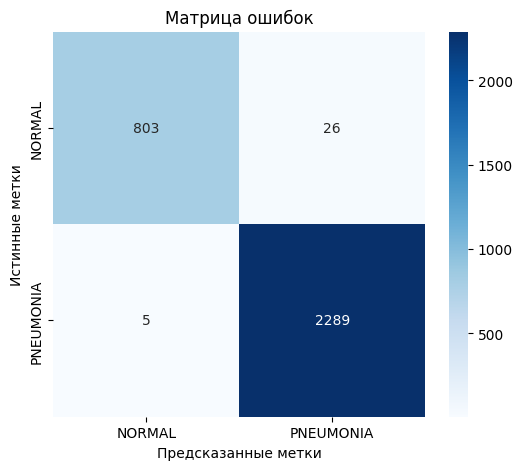

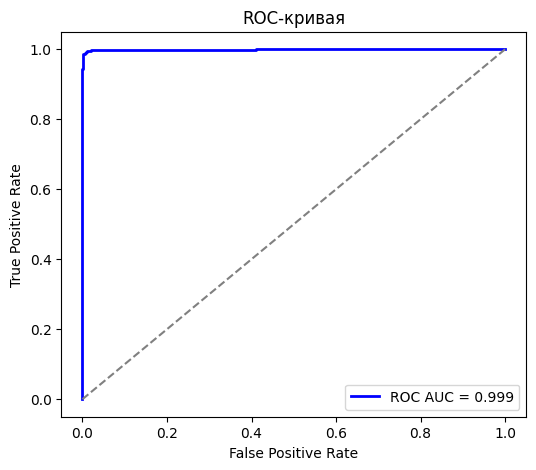

In [98]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_color_affine)

In [88]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_base_color_affine'] = 0.9933


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817, 'model_resnet_affine': 0.976, 'model_resnet_blur': 0.9885, 'model_resnet_base_blur': 0.9875, 'model_resnet_base_color': 0.9856, 'model_resnet_base_color_affine': 0.9933}


Тестирование: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       1.00      0.34      0.50       234
   PNEUMONIA       0.72      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.86      0.67      0.67       624
weighted avg       0.82      0.75      0.71       624

Accuracy: 0.7516
Матрица ошибок:
[[ 79 155]
 [  0 390]]


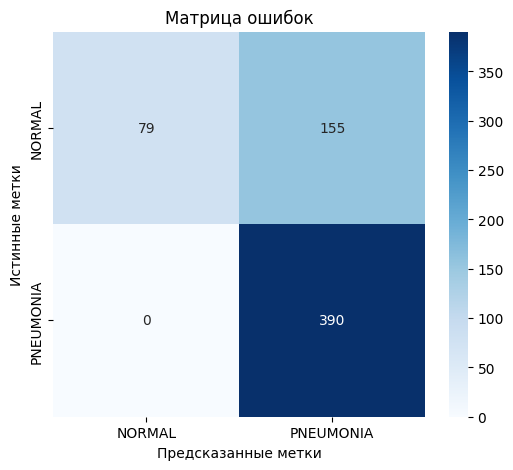

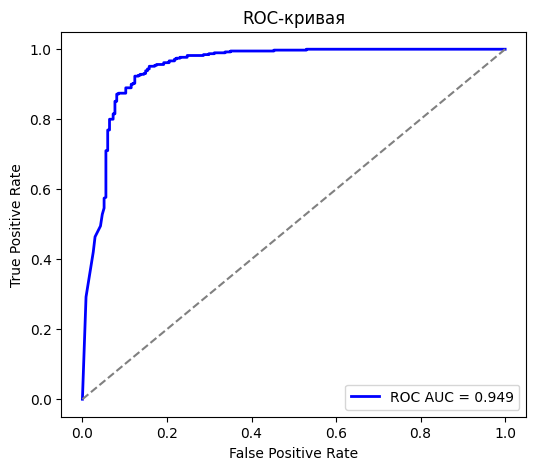

In [89]:
evaluate_model(model_resnet, test_loader)

## Сравнение аугментаций

In [107]:
import pandas as pd
df = pd.DataFrame.from_dict(models_accuracy, orient='index', columns=['Accuracy'])
df = df.sort_values(by='Accuracy', ascending=False)
print("Результаты моделей:")

Результаты моделей:


In [108]:
df

Accuracy
model_resnet_base_blur_affine     0.9949
model_resnet_base_color_affine    0.9933
model_resnet_base_blur_color      0.9910
model_resnet_blur                 0.9885
model_resnet_base_blur            0.9875
model_resnet_base_color           0.9856
model_resnet_base                 0.9827
model_resnet_color                0.9817
model_resnet_affine               0.9760
model_resnet_rotate               0.9750

In [143]:
model_metrics

[{'model_name': 'resnet_base',
  'metrics': {'Accuracy': 0.9827,
   'Precision': 0.9848,
   'Recall': 0.9924,
   'F1-score': 0.9886}},
 {'model_name': 'resnet_rotate',
  'metrics': {'Accuracy': 0.9827,
   'Precision': 0.9848,
   'Recall': 0.9924,
   'F1-score': 0.9886}},
 {'model_name': 'resnet_color',
  'metrics': {'Accuracy': 0.9914,
   'Precision': 0.9923,
   'Recall': 0.9962,
   'F1-score': 0.9942}},
 {'model_name': 'resnet_affine',
  'metrics': {'Accuracy': 0.976,
   'Precision': 0.9832,
   'Recall': 0.9832,
   'F1-score': 0.9832}},
 {'model_name': 'resnet_blur',
  'metrics': {'Accuracy': 0.976,
   'Precision': 0.9947,
   'Recall': 0.9729,
   'F1-score': 0.9837}},
 {'model_name': 'resnet_base_blur',
  'metrics': {'Accuracy': 0.9861,
   'Precision': 0.9897,
   'Recall': 0.9916,
   'F1-score': 0.9906}},
 {'model_name': 'resnet_base_color',
  'metrics': {'Accuracy': 0.9938,
   'Precision': 0.9994,
   'Recall': 0.9923,
   'F1-score': 0.9958}},
 {'model_name': 'resnet_base_blur_affine'


=== PERFORMANCE BENCHMARK REPORT ===
+--------+--------------------------+---------------+-------------+----------+------------+----------+
|   Rank | Model                    | Accuracy Δ    |   Precision |   Recall |   F1-score |   Score* |
+========+==========================+===============+=============+==========+============+==========+
|      1 | resnet_base_blur_color   | 0.0000 (best) |      0.9957 |   0.9991 |     0.9974 |   0.9968 |
+--------+--------------------------+---------------+-------------+----------+------------+----------+
|      2 | resnet_base_color_affine | -0.0020       |      0.9949 |   0.9975 |     0.9962 |   0.9952 |
+--------+--------------------------+---------------+-------------+----------+------------+----------+
|      3 | resnet_base_color        | -0.0024       |      0.9994 |   0.9923 |     0.9958 |   0.9948 |
+--------+--------------------------+---------------+-------------+----------+------------+----------+
|      4 | resnet_color            

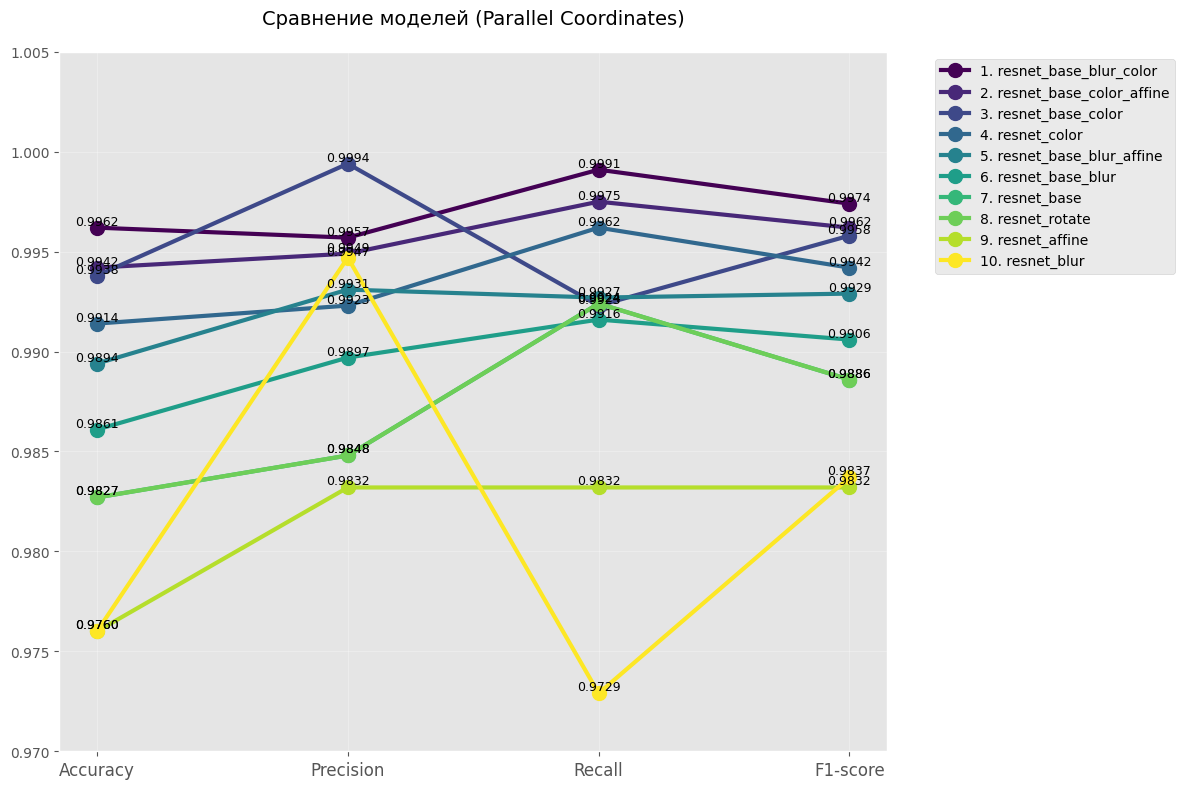

In [142]:
from colorama import Fore, Style
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

def visualize_performance(metrics):
    """Улучшенная визуализация с параллельными координатами"""
    metrics_sorted = sorted(metrics, key=lambda x: x['metrics']['Accuracy'], reverse=True)

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.style.use('ggplot')

    # Подготовка данных
    categories = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    y_values = np.array([[m['metrics'][k] for k in categories] for m in metrics_sorted])
    x = range(len(categories))

    # Цветовая схема
    colors = plt.cm.viridis(np.linspace(0, 1, len(metrics_sorted)))

    # Построение линий для каждой модели
    for i, (model, color) in enumerate(zip(metrics_sorted, colors)):
        ax.plot(x, y_values[i],
               marker='o',
               color=color,
               linewidth=3,
               markersize=10,
               label=f"{i+1}. {model['model_name']}")

    # Настройка графика
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_ylim(0.97, 1.005)
    ax.set_title('Сравнение моделей (Parallel Coordinates)', fontsize=14, pad=20)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    # Добавление значений метрик
    for i, model in enumerate(metrics_sorted):
        for j, metric in enumerate(categories):
            ax.text(j, y_values[i][j], f"{y_values[i][j]:.4f}",
                   ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def generate_report(metrics):
    """Генерация полного отчёта с анализом"""
    metrics_sorted = sorted(metrics, key=lambda x: x['metrics']['Accuracy'], reverse=True)

    # Сохранение в JSON
    with open('model_metrics.json', 'w') as f:
        json.dump(metrics_sorted, f, indent=4)

    # Подготовка данных для таблицы
    headers = [
        "Rank", "Model",
        "Accuracy Δ", "Precision",
        "Recall", "F1-score",
        "Score*"
    ]

    table_data = []
    top_acc = metrics_sorted[0]['metrics']['Accuracy']

    for i, model in enumerate(metrics_sorted, 1):
        m = model['metrics']
        acc_diff = m['Accuracy'] - top_acc if i > 1 else 0
        score = (m['Accuracy'] + m['F1-score']) / 2  # Композитный показатель

        table_data.append([
            i,
            model['model_name'],
            f"{acc_diff:+.4f}" if i > 1 else "0.0000 (best)",
            f"{m['Precision']:.4f}",
            f"{m['Recall']:.4f}",
            f"{m['F1-score']:.4f}",
            f"{score:.4f}"
        ])

    # Вывод в консоль
    print(f"\n{Fore.YELLOW}=== PERFORMANCE BENCHMARK REPORT ==={Style.RESET_ALL}")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # Анализ лучшей модели
    best = metrics_sorted[0]
    print(f"\n{Fore.GREEN}>>> BEST MODEL: {best['model_name'].upper()}{Style.RESET_ALL}")
    print(f"Composite Score: {(best['metrics']['Accuracy'] + best['metrics']['F1-score'])/2:.4f}")
    print(f"Key Advantages:")
    print(f"- Recall: {best['metrics']['Recall']:.4f} (лучший показатель)")
    print(f"- Balanced: Accuracy {best['metrics']['Accuracy']:.4f} | F1 {best['metrics']['F1-score']:.4f}")

    # Визуализация
    visualize_performance(metrics_sorted)

# Генерация отчёта
generate_report(model_metrics)


In [123]:
model_metrics

[{'model_name': 'resnet_base',
  'metrics': {'Accuracy': 0.9827,
   'Precision': 0.9848,
   'Recall': 0.9924,
   'F1-score': 0.9886}},
 {'model_name': 'resnet_rotate',
  'metrics': {'Accuracy': 0.9827,
   'Precision': 0.9848,
   'Recall': 0.9924,
   'F1-score': 0.9886}},
 {'model_name': 'resnet_color',
  'metrics': {'Accuracy': 0.9923,
   'Precision': 0.9949,
   'Recall': 0.9949,
   'F1-score': 0.9949}},
 {'model_name': 'resnet_color',
  'metrics': {'Accuracy': 0.9923,
   'Precision': 0.9949,
   'Recall': 0.9949,
   'F1-score': 0.9949}},
 {'model_name': 'resnet_blur',
  'metrics': {'Accuracy': 0.976,
   'Precision': 0.9947,
   'Recall': 0.9729,
   'F1-score': 0.9837}},
 {'model_name': 'resnet_base_blur',
  'metrics': {'Accuracy': 0.976,
   'Precision': 0.9947,
   'Recall': 0.9729,
   'F1-score': 0.9837}},
 {'model_name': 'resnet_base_color',
  'metrics': {'Accuracy': 0.9938,
   'Precision': 0.9994,
   'Recall': 0.9923,
   'F1-score': 0.9958}},
 {'model_name': 'resnet_base_blur_affine',

In [109]:
pip install colorama

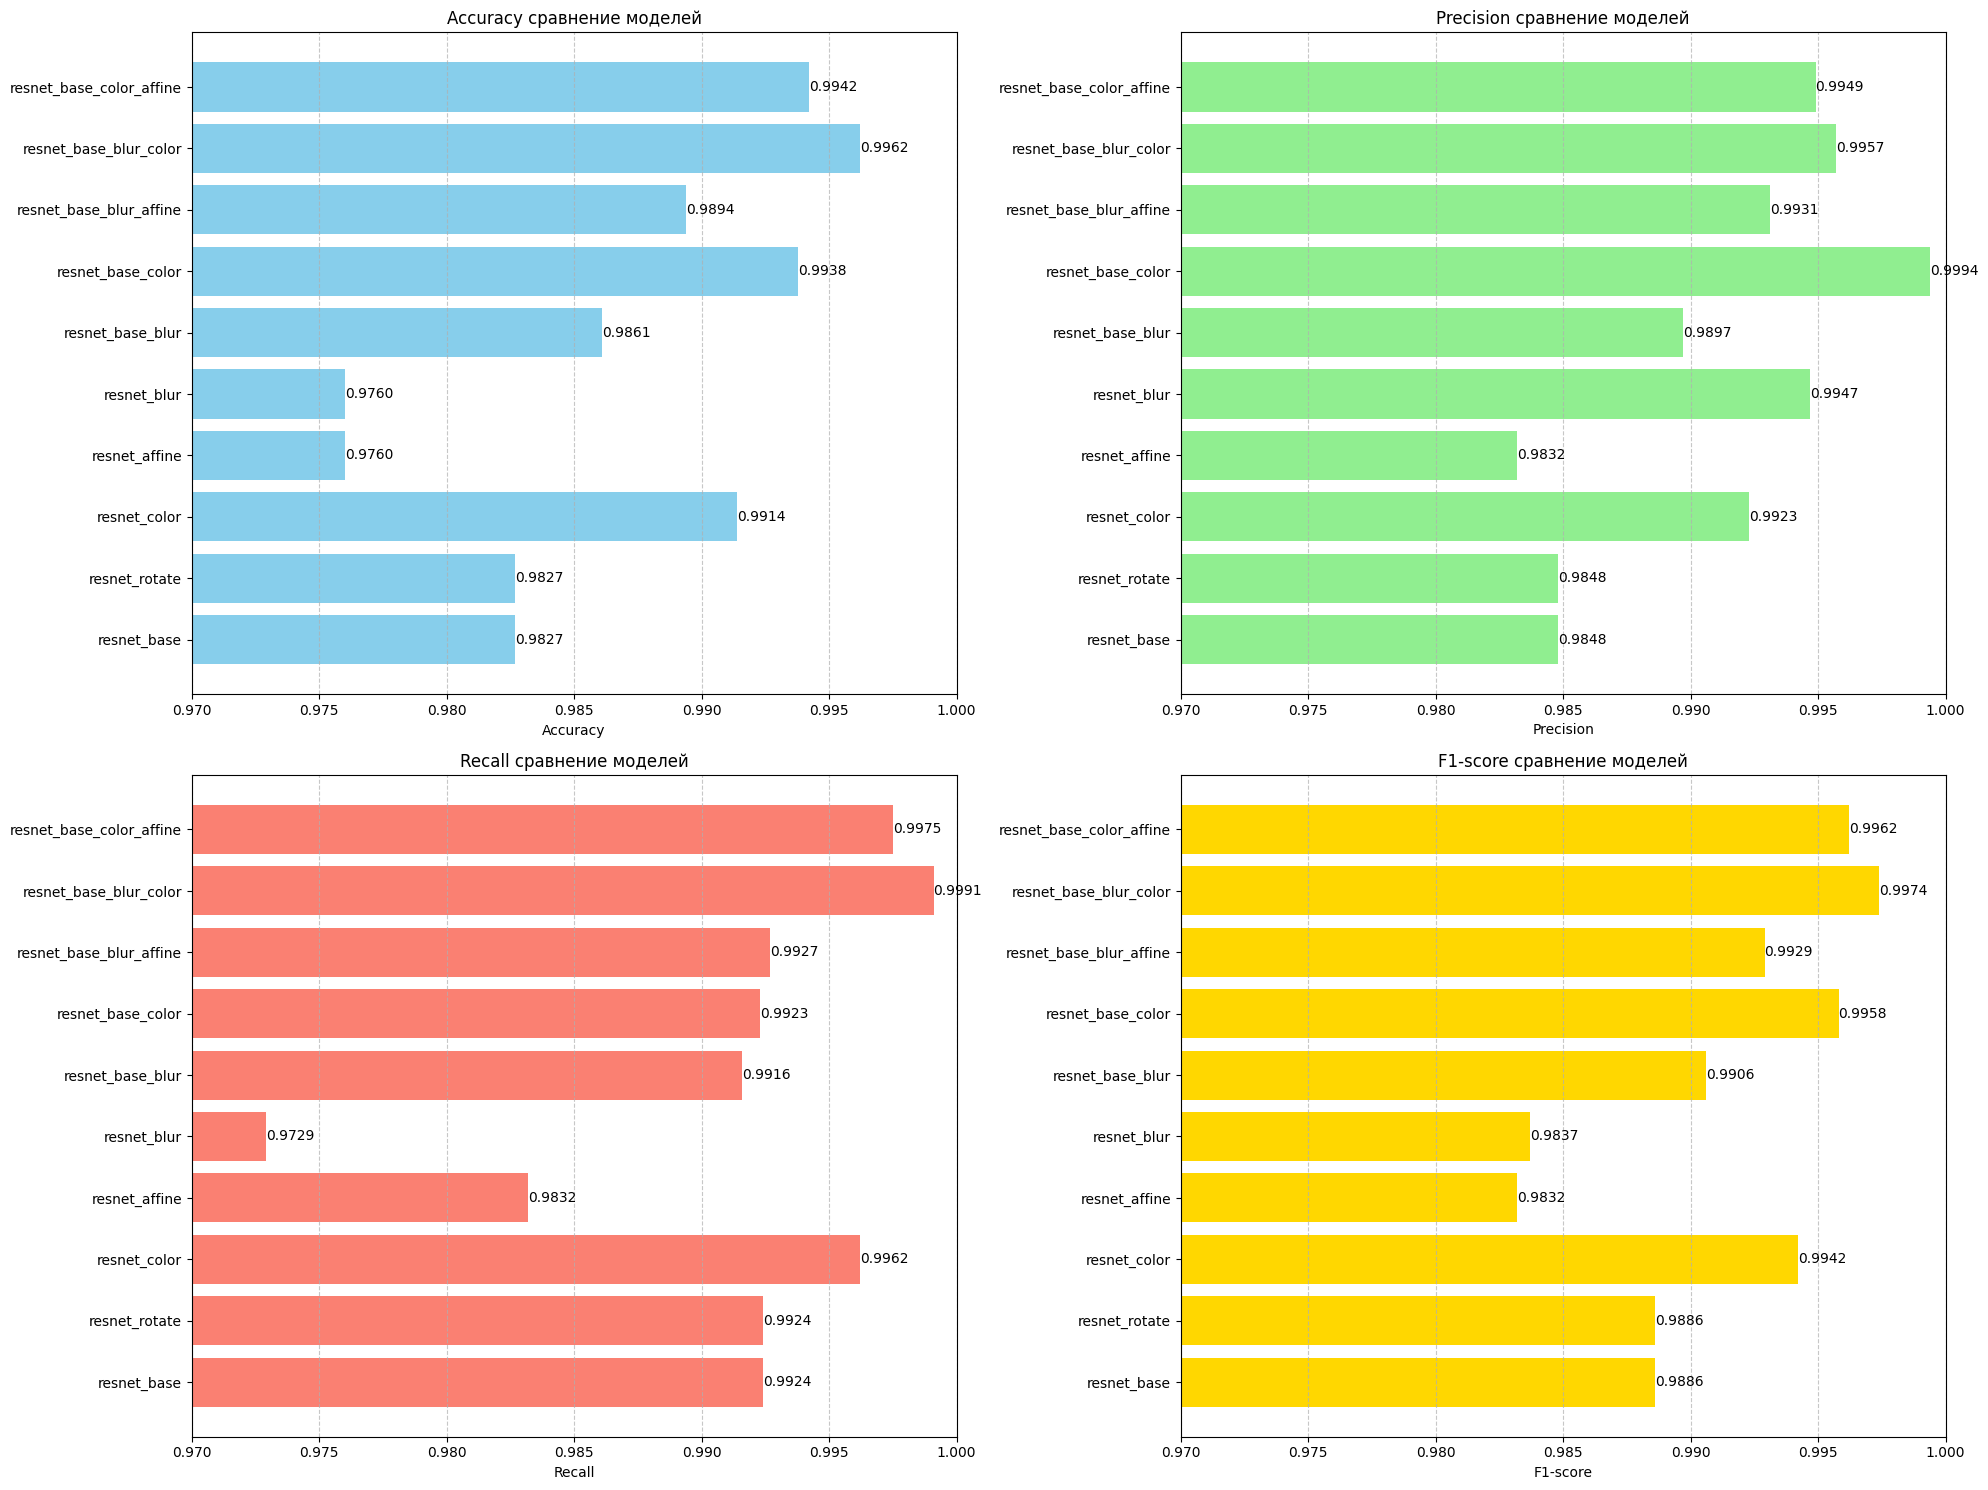

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Данные моделей
models = [
    {'model_name': 'resnet_base', 'metrics': {'Accuracy': 0.9827, 'Precision': 0.9848, 'Recall': 0.9924, 'F1-score': 0.9886}},
    {'model_name': 'resnet_rotate', 'metrics': {'Accuracy': 0.9827, 'Precision': 0.9848, 'Recall': 0.9924, 'F1-score': 0.9886}},
    {'model_name': 'resnet_color', 'metrics': {'Accuracy': 0.9914, 'Precision': 0.9923, 'Recall': 0.9962, 'F1-score': 0.9942}},
    {'model_name': 'resnet_affine', 'metrics': {'Accuracy': 0.976, 'Precision': 0.9832, 'Recall': 0.9832, 'F1-score': 0.9832}},
    {'model_name': 'resnet_blur', 'metrics': {'Accuracy': 0.976, 'Precision': 0.9947, 'Recall': 0.9729, 'F1-score': 0.9837}},
    {'model_name': 'resnet_base_blur', 'metrics': {'Accuracy': 0.9861, 'Precision': 0.9897, 'Recall': 0.9916, 'F1-score': 0.9906}},
    {'model_name': 'resnet_base_color', 'metrics': {'Accuracy': 0.9938, 'Precision': 0.9994, 'Recall': 0.9923, 'F1-score': 0.9958}},
    {'model_name': 'resnet_base_blur_affine', 'metrics': {'Accuracy': 0.9894, 'Precision': 0.9931, 'Recall': 0.9927, 'F1-score': 0.9929}},
    {'model_name': 'resnet_base_blur_color', 'metrics': {'Accuracy': 0.9962, 'Precision': 0.9957, 'Recall': 0.9991, 'F1-score': 0.9974}},
    {'model_name': 'resnet_base_color_affine', 'metrics': {'Accuracy': 0.9942, 'Precision': 0.9949, 'Recall': 0.9975, 'F1-score': 0.9962}}
]

# Извлекаем названия моделей и метрики
model_names = [m['model_name'] for m in models]
accuracy = [m['metrics']['Accuracy'] for m in models]
precision = [m['metrics']['Precision'] for m in models]
recall = [m['metrics']['Recall'] for m in models]
f1 = [m['metrics']['F1-score'] for m in models]

# Создаем фигуру с 4 подграфиками
plt.figure(figsize=(20, 15))

# График Accuracy
plt.subplot(2, 2, 1)
bars = plt.barh(model_names, accuracy, color='skyblue')
plt.xlim(0.97, 1.0)
plt.title('Accuracy сравнение моделей')
plt.xlabel('Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center')

# График Precision
plt.subplot(2, 2, 2)
bars = plt.barh(model_names, precision, color='lightgreen')
plt.xlim(0.97, 1.0)
plt.title('Precision сравнение моделей')
plt.xlabel('Precision')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center')

# График Recall
plt.subplot(2, 2, 3)
bars = plt.barh(model_names, recall, color='salmon')
plt.xlim(0.97, 1.0)
plt.title('Recall сравнение моделей')
plt.xlabel('Recall')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center')

# График F1-score
plt.subplot(2, 2, 4)
bars = plt.barh(model_names, f1, color='gold')
plt.xlim(0.97, 1.0)
plt.title('F1-score сравнение моделей')
plt.xlabel('F1-score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [109]:
from google.colab import files
files.download('best_model_blur.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [110]:
!zip -r models.zip best_model.pth best_model_affine.pth best_model_base_blur.pth best_model_base_blur_affine.pth best_model_base_color.pth best_model_base_blur_color.pth  best_model_base_color_affine.pth best_model_color.pth best_model_rotate.pth best_model_base_color.pth best_model_base_blur_affine.pth
files.download('models.zip')

  adding: best_model.pth (deflated 7%)
  adding: best_model_affine.pth (deflated 7%)
  adding: best_model_base_blur.pth (deflated 7%)
  adding: best_model_base_blur_affine.pth (deflated 7%)
  adding: best_model_base_color.pth (deflated 7%)
  adding: best_model_base_blur_color.pth (deflated 7%)
  adding: best_model_base_color_affine.pth (deflated 7%)
  adding: best_model_color.pth (deflated 7%)
  adding: best_model_rotate.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Мы видим, что сдвиг и поворот дают наихудший результат. Поэтому остановились на варианте обогащения текущего датасета изображениями с размытием и сдвигом. Таким образом, объем датасета увеличен в 3 раза.

## Взвешивание классов

In [ ]:
# Функция для вычисления весов классов
def get_class_weights(dataset):
    # Получаем метки из исходного датасета
    targets = torch.tensor(dataset.dataset.targets)[dataset.indices]  # Преобразуем в тензор и индексируем

    # Вычисляем количество элементов в каждом классе
    class_counts = torch.bincount(targets)
    # Вычисляем веса как обратную частоту
    class_weights = 1. / class_counts
    return class_weights

In [ ]:
# Получение весов классов
class_weights = get_class_weights(train_data_base)
class_weights = class_weights.to(device)

# Создание WeightedRandomSampler для oversampling
sampler = WeightedRandomSampler(class_weights, len(class_weights), replacement=True)


# Загрузка предобученной модели ResNet18
model_resnet_sampler = models.resnet18(pretrained=True)

# Замена последнего слоя на новый (2 класса)
model_resnet_sampler.fc = nn.Linear(model_resnet_sampler.fc.in_features, 2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet_sampler = model_resnet_sampler.to(device)

# Определение функции потерь с весами классов
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Определение оптимизатора
optimizer = optim.Adam(model_resnet_sampler.parameters(), lr=0.001)
# Обучение модели
train_model(model_resnet_sampler, train_loader_base_color_affine, val_loader_base_color_affine, criterion, optimizer, num_epochs=10, save_path="best_model_resnet_weighted.pth")

# Загрузка лучшей модели
model_resnet_sampler.load_state_dict(torch.load("best_model_resnet_weighted.pth"))


Эпоха 1/10
----------


Тренировка: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]


Train loss: 0.1127, train accuracy: 96.0704


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.67it/s]


Val_loss: 0.0569, Val_accuracy: 98.8793
Модель сохранена с точностью 98.8793
Epoch  0  |  Time: 57.80s  |  Est. remaining: 0.00s
Train Loss: 0.112712  |  Val Loss: 0.056946
Train Accuracy: 96.07%  |  Val Accuracy: 98.88%
Эпоха 2/10
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.82it/s]


Train loss: 0.0483, train accuracy: 98.3113


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.58it/s]


Val_loss: 0.0388, Val_accuracy: 98.2069
Epoch  1  |  Time: 55.75s  |  Est. remaining: 454.21s
Train Loss: 0.048309  |  Val Loss: 0.038751
Train Accuracy: 98.31%  |  Val Accuracy: 98.21%
Эпоха 3/10
----------


Тренировка: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s]


Train loss: 0.0494, train accuracy: 98.1673


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.61it/s]


Val_loss: 0.0732, Val_accuracy: 96.7019
Epoch  2  |  Time: 55.34s  |  Est. remaining: 394.08s
Train Loss: 0.049393  |  Val Loss: 0.073214
Train Accuracy: 98.17%  |  Val Accuracy: 96.70%
Эпоха 4/10
----------


Тренировка: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s]


Train loss: 0.0333, train accuracy: 98.8235


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.49it/s]


Val_loss: 0.0285, Val_accuracy: 98.9113
Модель сохранена с точностью 98.9113
Epoch  3  |  Time: 55.55s  |  Est. remaining: 336.66s
Train Loss: 0.033302  |  Val Loss: 0.028515
Train Accuracy: 98.82%  |  Val Accuracy: 98.91%
Эпоха 5/10
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.87it/s]


Train loss: 0.0334, train accuracy: 98.9516


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.70it/s]


Val_loss: 0.0337, Val_accuracy: 99.1995
Модель сохранена с точностью 99.1995
Epoch  4  |  Time: 55.49s  |  Est. remaining: 279.92s
Train Loss: 0.033438  |  Val Loss: 0.033737
Train Accuracy: 98.95%  |  Val Accuracy: 99.20%
Эпоха 6/10
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.76it/s]


Train loss: 0.0231, train accuracy: 99.1757


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.60it/s]


Val_loss: 0.0174, Val_accuracy: 99.4236
Модель сохранена с точностью 99.4236
Epoch  5  |  Time: 56.16s  |  Est. remaining: 224.06s
Train Loss: 0.023098  |  Val Loss: 0.017427
Train Accuracy: 99.18%  |  Val Accuracy: 99.42%
Эпоха 7/10
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.76it/s]


Train loss: 0.0239, train accuracy: 99.0716


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.70it/s]


Val_loss: 0.0355, Val_accuracy: 98.5591
Epoch  6  |  Time: 55.89s  |  Est. remaining: 167.99s
Train Loss: 0.023930  |  Val Loss: 0.035533
Train Accuracy: 99.07%  |  Val Accuracy: 98.56%
Эпоха 8/10
----------


Тренировка: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s]


Train loss: 0.0261, train accuracy: 99.1116


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.61it/s]


Val_loss: 0.0158, Val_accuracy: 99.6798
Модель сохранена с точностью 99.6798
Epoch  7  |  Time: 55.43s  |  Est. remaining: 111.85s
Train Loss: 0.026069  |  Val Loss: 0.015837
Train Accuracy: 99.11%  |  Val Accuracy: 99.68%
Эпоха 9/10
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.82it/s]


Train loss: 0.0129, train accuracy: 99.5358


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


Val_loss: 0.0349, Val_accuracy: 99.1355
Epoch  8  |  Time: 55.69s  |  Est. remaining: 55.90s
Train Loss: 0.012861  |  Val Loss: 0.034851
Train Accuracy: 99.54%  |  Val Accuracy: 99.14%
Эпоха 10/10
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.79it/s]


Train loss: 0.0450, train accuracy: 98.4634


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.71it/s]

Val_loss: 0.0203, Val_accuracy: 99.0714
Epoch  9  |  Time: 55.74s  |  Est. remaining: 0.00s
Train Loss: 0.045045  |  Val Loss: 0.020345
Train Accuracy: 98.46%  |  Val Accuracy: 99.07%
--------------------------------------------------
Обучение завершено за 558.84 секунд
Среднее время эпохи: 55.88s
Лучшая точность на валидации: 99.6798


<All keys matched successfully>

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Отчет о классификации:
              precision    recall  f1-score   support

      NORMAL       0.99      1.00      0.99       807
   PNEUMONIA       1.00      1.00      1.00      2316

    accuracy                           1.00      3123
   macro avg       1.00      1.00      1.00      3123
weighted avg       1.00      1.00      1.00      3123

Accuracy: 0.9971
Матрица ошибок:
[[ 804    3]
 [   6 2310]]


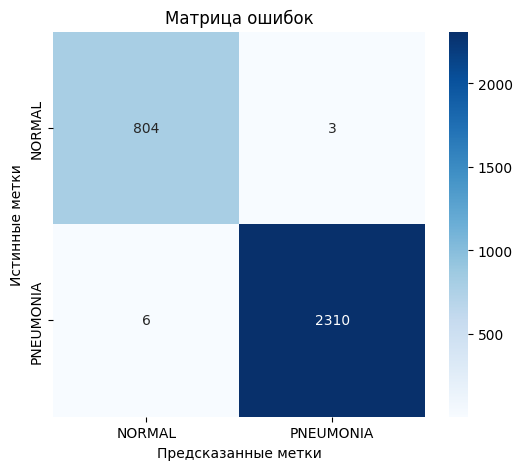

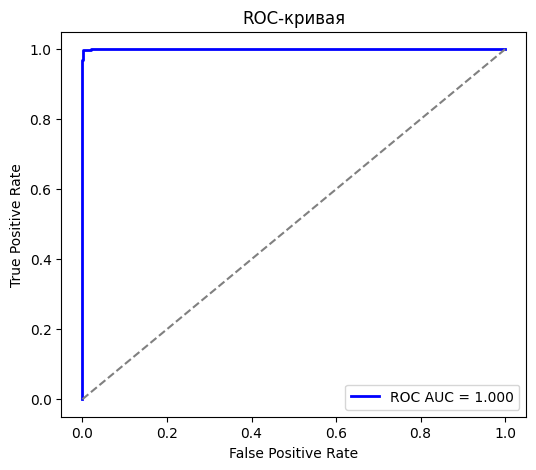

In [ ]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_resnet_weighted.pth")

# Затем загружаем только веса модели
model_resnet_sampler.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet_sampler, val_loader_base_color_affine)

Тестирование: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]


Отчет о классификации:
              precision    recall  f1-score   support

      NORMAL       1.00      0.47      0.64       234
   PNEUMONIA       0.76      1.00      0.86       390

    accuracy                           0.80       624
   macro avg       0.88      0.74      0.75       624
weighted avg       0.85      0.80      0.78       624

Accuracy: 0.8029
Матрица ошибок:
[[111 123]
 [  0 390]]


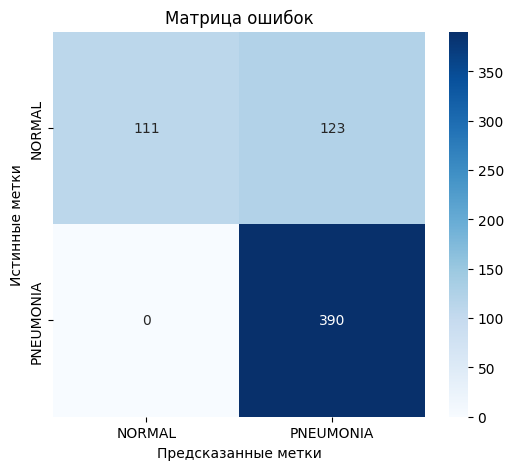

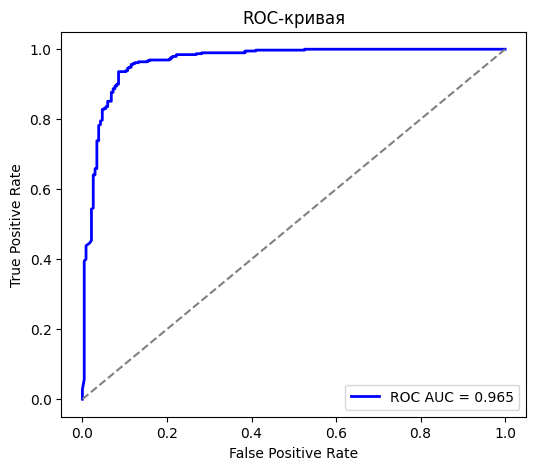

In [ ]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_resnet_weighted.pth")

# Затем загружаем только веса модели
model_resnet_sampler.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet_sampler, test_loader)